In [1]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict

In [2]:
df1 = pd.read_csv(r"../../data/trip_duration_processed.csv", index_col=0)
df2 = pd.read_csv(r"../../data/airlines_label_encoding.csv", index_col=0)

In [3]:
X1 = df1.drop(columns=['trip_duration'], axis=1)
y1 = df1['trip_duration']

In [4]:
X2 = df2.drop(columns=['Delay'], axis=1)
y2 = df2['Delay']

# Оптимизируем признаковое пространство методом SelectKBest

In [5]:
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler

In [6]:
skb1 = SelectKBest(k=2)

In [7]:
X_reg = skb1.fit_transform(X1, y1)

In [8]:
ss = StandardScaler()
X_reg = ss.fit_transform(X_reg)

In [9]:
pd.DataFrame(X_reg, columns=skb1.get_feature_names_out()).head()

,dropoff_latitude,distance
0,0.675661,-0.693608
1,-2.165347,0.887547
2,0.815550,3.142706
3,1.028370,-0.126936
4,-0.462221,1.263624


In [10]:
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y1, test_size=0.2)

In [11]:
skb2 = SelectKBest(k=2)

In [12]:
X_cl = skb2.fit_transform(X2, y2)

In [13]:
pd.DataFrame(X_cl, columns=skb2.get_feature_names_out()).head()

,Flight,Time
0,3036.0,1195.0
1,315.0,707.0
2,6673.0,499.0
3,3668.0,810.0
4,623.0,985.0


In [14]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X_cl, y2, test_size=0.2)

In [15]:
y2_train.value_counts()

Delay
0    127814
1     65569
Name: count, dtype: int64

In [16]:
from imblearn.over_sampling import RandomOverSampler

In [17]:
ros = RandomOverSampler()
X_cl_train, y_cl_train = ros.fit_resample(X2_train, y2_train)
X_cl_test = X2_test
y_cl_test = y2_test

C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [18]:
y_cl_train.value_counts()

Delay
0    127814
1    127814
Name: count, dtype: int64

# 1. FCNN (MLP) из Sklearn

In [82]:
from sklearn.model_selection import RandomizedSearchCV

## Регрессия

### RandomizedSearch

In [83]:
from sklearn.neural_network import MLPRegressor

In [84]:
mlp_reg = MLPRegressor(
    solver='sgd',
    max_iter=10000,
    activation='tanh'
)

In [85]:
mlp_reg_params = {"hidden_layer_sizes" : [4, 10, 16, 45, 64]}

In [86]:
mlp_reg_models = RandomizedSearchCV(
    estimator=mlp_reg,
    param_distributions=mlp_reg_params,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
).fit(X_reg_train[:2000], y_reg_train[:2000])

C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [87]:
mlp_reg_models.best_params_

{'hidden_layer_sizes': 64}

In [88]:
mlp_reg = mlp_reg_models.best_estimator_

In [76]:
neural_avg_scores = mlp_reg_models.cv_results_["mean_test_score"]

In [77]:
for i in range(0, 5):
    print("{:>3} : {:0.3f}"
        .format(mlp_reg_params['hidden_layer_sizes'][i], -neural_avg_scores[i]))

  4 : 230.556
 10 : 217.060
 16 : 210.442
 45 : 206.242
 64 : 204.268


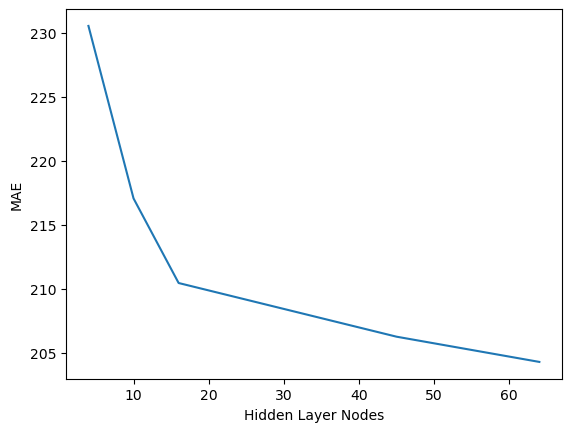

In [78]:
plt.plot(
    mlp_reg_params['hidden_layer_sizes'],
    -neural_avg_scores)
plt.xlabel("Hidden Layer Nodes")
plt.ylabel("MAE")
plt.show()

In [79]:
print("Число слоев (включая входной и выходной):", mlp_reg.n_layers_)
print("Число выходных классов:", mlp_reg.n_outputs_)
print("Форма каждого слоя:")
for i, (w, b) in enumerate(zip(mlp_reg.coefs_, mlp_reg.intercepts_)):
    print(f"  Слой {i}: входы = {w.shape[0]}, выходы = {w.shape[1]}")

Число слоев (включая входной и выходной): 3
Число выходных классов: 1
Форма каждого слоя:
  Слой 0: входы = 2, выходы = 64
  Слой 1: входы = 64, выходы = 1


In [80]:
mlp_reg_epochs = 1000

In [83]:
y_pred_mlp_reg = mlp_reg.predict(X_reg_test)
mlp_reg_mse = mean_squared_error(y_reg_test, y_pred_mlp_reg)
mlp_reg_mae = mean_absolute_error(y_reg_test, y_pred_mlp_reg)
mlp_reg_r2 = r2_score(y_reg_test, y_pred_mlp_reg)

In [256]:
print(f"MSE: {mlp_reg_mse:.2f}")
print(f"MAE: {mlp_reg_mae:.2f}")
print(f"R2: {mlp_reg_r2:.2f}")

MSE: 79621.76
MAE: 210.61
R2: 0.51


In [140]:
y_pred_mlp_reg_train = mlp_reg.predict(X_reg_train)
mlp_reg_mse_train = mean_squared_error(y_reg_train, y_pred_mlp_reg_train)
mlp_reg_mae_train = mean_absolute_error(y_reg_train, y_pred_mlp_reg_train)
mlp_reg_r2_train = r2_score(y_reg_train, y_pred_mlp_reg_train)

In [255]:
print(f"MSE: {mlp_reg_mse_train:.2f}")
print(f"MAE: {mlp_reg_mae_train:.2f}")
print(f"R2: {mlp_reg_r2_train:.2f}")

MSE: 79427.66
MAE: 210.29
R2: 0.52


### Optuna

In [92]:
import optuna
from sklearn.model_selection import cross_val_score

In [93]:
def objective(trial):
    hidden_layer_sizes = tuple([trial.suggest_int("n_units_l{}".format(i), 10, 100) for i in range(trial.suggest_int("n_layers", 1, 3))])
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-4, 1e-1, log=True)
    alpha = trial.suggest_float("alpha", 1e-5, 1e-1, log=True)
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "logistic"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])

    model = MLPRegressor(
        solver="sgd",
        learning_rate_init=learning_rate_init,
        hidden_layer_sizes=hidden_layer_sizes,
        alpha=alpha,
        activation=activation,
        batch_size=batch_size,
        max_iter=1000,
        random_state=42
    )

    score = cross_val_score(model, X_reg_train[:2000], y_reg_train[:2000], cv=3, scoring="neg_mean_squared_error")
    return -np.mean(score)

In [95]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-05-29 17:45:50,270] A new study created in memory with name: no-name-ef269896-e454-4ea5-b99b-44301bd98ff9
[I 2025-05-29 17:45:52,520] Trial 0 finished with value: 155340.58448949995 and parameters: {'n_layers': 3, 'n_units_l0': 39, 'n_units_l1': 91, 'n_units_l2': 45, 'learning_rate_init': 0.0001559133149745588, 'alpha': 0.029342620966139384, 'activation': 'tanh', 'batch_size': 64}. Best is trial 0 with value: 155340.58448949995.
[I 2025-05-29 17:45:53,162] Trial 1 finished with value: 155438.38849249168 and parameters: {'n_layers': 2, 'n_units_l0': 27, 'n_units_l1': 33, 'learning_rate_init': 0.0006587717325668324, 'alpha': 0.00030148686972256367, 'activation': 'tanh', 'batch_size': 64}. Best is trial 0 with value: 155340.58448949995.
[I 2025-05-29 17:45:57,064] Trial 2 finished with value: 155391.9900128242 and parameters: {'n_layers': 3, 'n_units_l0': 81, 'n_units_l1': 86, 'n_units_l2': 17, 'learning_rate_init': 0.0007556740168190391, 'alpha': 1.0898913669452795e-05, 'activati

ValueError: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 754, in fit
    return self._fit(X, y, incremental=False)
  File "C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 496, in _fit
    raise ValueError(
ValueError: Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.


In [96]:
print("Лучшие параметры:", study.best_params)
print("Лучшая ошибка:", study.best_value)

Лучшие параметры: {'n_layers': 3, 'n_units_l0': 39, 'n_units_l1': 91, 'n_units_l2': 45, 'learning_rate_init': 0.0001559133149745588, 'alpha': 0.029342620966139384, 'activation': 'tanh', 'batch_size': 64}
Лучшая ошибка: 155340.58448949995


In [260]:
from sklearn.neural_network import MLPRegressor

best_params = study.best_params.copy()

n_layers = sum(k.startswith("n_units_l") for k in best_params)
hidden_layer_sizes = tuple(best_params[f"n_units_l{i}"] for i in range(n_layers))

final_model_optuna = MLPRegressor(
    solver="sgd",
    learning_rate_init=best_params["learning_rate_init"],
    hidden_layer_sizes=hidden_layer_sizes,
    alpha=best_params["alpha"],
    activation=best_params["activation"],
    batch_size=best_params["batch_size"],
    max_iter=1000,
    random_state=42
)

final_model_optuna.fit(X_reg_train[:5000], y_reg_train[:5000])

MLPRegressor(alpha=0.0004827958479974002, batch_size=128,
             hidden_layer_sizes=(35,),
             learning_rate_init=0.00015767361988568742, max_iter=1000,
             random_state=42, solver='sgd')

In [261]:
y_pred = final_model_optuna.predict(X_reg_test)
mse = mean_squared_error(y_reg_test, y_pred)
mae = mean_absolute_error(y_reg_test, y_pred)
r2 = r2_score(y_reg_test, y_pred)

In [262]:
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²:  {r2:.2f}")

MSE: 79477.33
MAE: 212.06
R²:  0.52


In [263]:
y_pred = final_model_optuna.predict(X_reg_train)
mse = mean_squared_error(y_reg_train, y_pred)
mae = mean_absolute_error(y_reg_train, y_pred)
r2 = r2_score(y_reg_train, y_pred)

In [264]:
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²:  {r2:.2f}")

MSE: 79496.83
MAE: 211.90
R²:  0.52


### Hyperopt

In [114]:
import hyperopt

In [119]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK


space = {
    'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [
        (50,), (100,), (50, 50), (100, 50), (100, 100)
    ]),
    'learning_rate_init': hp.loguniform('learning_rate_init', np.log(1e-4), np.log(1e-1)),
    'alpha': hp.loguniform('alpha', np.log(1e-5), np.log(1e-1)),
    'activation': hp.choice('activation', ['relu', 'tanh', 'logistic']),
    'batch_size': hp.choice('batch_size', [16, 32, 64, 128]),
}

def objective(params):
    model = MLPRegressor(
        solver='sgd',
        max_iter=1000,
        random_state=42,
        **params
    )
    score = cross_val_score(model, X_reg_train[:2000], y_reg_train[:2000], cv=3, scoring='neg_mean_squared_error')
    return {
        'loss': -np.mean(score),  
        'status': STATUS_OK
    }

In [120]:
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
)

  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b

C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b

C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(

C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b

C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\neural_network\_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2

C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: invalid value encounte

  2%|█▎                                                                 | 1/50 [00:36<30:11, 36.98s/trial, best loss=?]

C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(

C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
2 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Denis\Miniconda3\envs\myen

  4%|██                                                | 2/50 [00:38<13:03, 16.31s/trial, best loss: 158228.5144009549]

C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b

C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(

C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\neural_network\_base.py:172: RuntimeWarning: overflow encountered in square
  return ((y_true - y_pred) ** 2).mean() / 2

C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b

C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\utils\extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b

C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: Convergen

  4%|██                                                | 2/50 [02:22<56:48, 71.00s/trial, best loss: 158228.5144009549]


ValueError: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 754, in fit
    return self._fit(X, y, incremental=False)
  File "C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 496, in _fit
    raise ValueError(
ValueError: Solver produced non-finite parameter weights. The input data may contain large values and need to be preprocessed.


In [129]:
print("Лучшие параметры:", best_params)

Лучшие параметры: {'n_layers': 3, 'n_units_l0': 39, 'n_units_l1': 91, 'n_units_l2': 45, 'learning_rate_init': 0.0001559133149745588, 'alpha': 0.029342620966139384, 'activation': 'tanh', 'batch_size': 64}


In [138]:
mlp_hyperopt_reg = MLPRegressor(
    solver='sgd',
    batch_size=64,
    activation='tanh',
    alpha=0.0001559133149745588,
    max_iter=1000,
    random_state=42
).fit(X_reg_train[:2000], y_reg_train[:2000])

In [139]:
y_pred = mlp_hyperopt_reg.predict(X_reg_test)
mse = mean_squared_error(y_reg_test, y_pred)
mae = mean_absolute_error(y_reg_test, y_pred)
r2 = r2_score(y_reg_test, y_pred)
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²:  {r2:.2f}")

MSE: 80788.13
MAE: 215.96
R²:  0.51


In [160]:
y_pred = mlp_hyperopt_reg.predict(X_reg_train)
mse = mean_squared_error(y_reg_train, y_pred)
mae = mean_absolute_error(y_reg_train, y_pred)
r2 = r2_score(y_reg_train, y_pred)
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²:  {r2:.2f}")

MSE: 80587.98
MAE: 215.71
R²:  0.51


### Adam

In [ ]:
max_iters = np.arange(100, 2001, 200)
mae_scores = []

for max_iter in max_iters:
    model = MLPRegressor(
        solver='adam',
        max_iter=max_iter,
        activation='tanh',
        hidden_layer_sizes=64,
        random_state=42
    )
    model.fit(X_reg_train[:2000], y_reg_train[:2000])
    y_pred = model.predict(X_reg_test)
    mae = mean_absolute_error(y_reg_test, y_pred)
    mae_scores.append(mae)

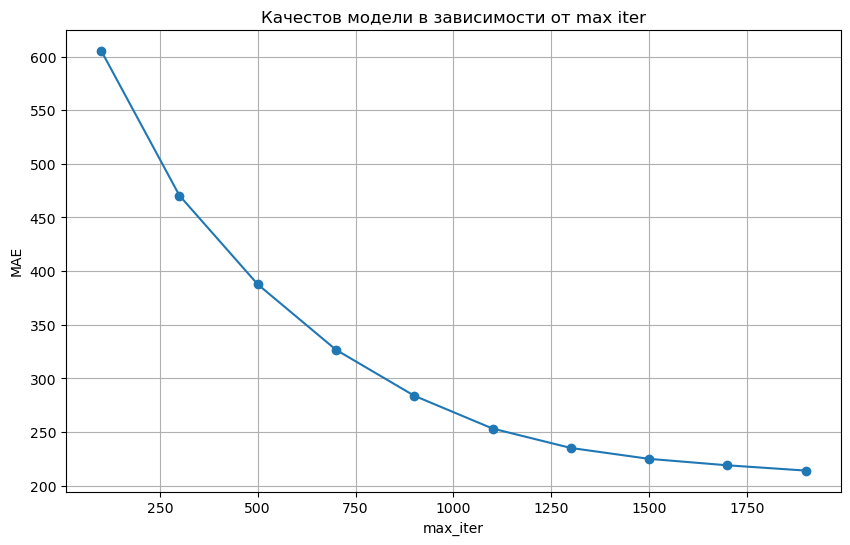

In [150]:
plt.figure(figsize=(10, 6))
plt.plot(max_iters, mae_scores, marker='o')
plt.title("Качестов модели в зависимости от max iter")
plt.xlabel("max_iter")
plt.ylabel("MAE")
plt.grid(True)
plt.show()

In [143]:
mlp_reg_adam = MLPRegressor(
    solver='adam',
    max_iter=10000,
    activation='tanh',
    hidden_layer_sizes=64
).fit(X_reg_train[:2000], y_reg_train[:2000])

In [144]:
y_pred = mlp_reg_adam.predict(X_reg_test)
mse = mean_squared_error(y_reg_test, y_pred)
mae = mean_absolute_error(y_reg_test, y_pred)
r2 = r2_score(y_reg_test, y_pred)
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²:  {r2:.2f}")

MSE: 78617.52
MAE: 208.04
R²:  0.52


In [161]:
y_pred = mlp_reg_adam.predict(X_reg_train)
mse = mean_squared_error(y_reg_train, y_pred)
mae = mean_absolute_error(y_reg_train, y_pred)
r2 = r2_score(y_reg_train, y_pred)
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²:  {r2:.2f}")

MSE: 78497.76
MAE: 207.90
R²:  0.52


### lbfgs

In [145]:
mlp_reg_lbfgs = MLPRegressor(
    solver='lbfgs',
    max_iter=10000,
    activation='tanh',
    hidden_layer_sizes=64
).fit(X_reg_train[:2000], y_reg_train[:2000])

In [146]:
y_pred = mlp_reg_lbfgs.predict(X_reg_test)
mse = mean_squared_error(y_reg_test, y_pred)
mae = mean_absolute_error(y_reg_test, y_pred)
r2 = r2_score(y_reg_test, y_pred)
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²:  {r2:.2f}")

MSE: 80827.78
MAE: 211.26
R²:  0.51


In [162]:
y_pred = mlp_reg_lbfgs.predict(X_reg_train)
mse = mean_squared_error(y_reg_train, y_pred)
mae = mean_absolute_error(y_reg_train, y_pred)
r2 = r2_score(y_reg_train, y_pred)
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²:  {r2:.2f}")

MSE: 80543.81
MAE: 210.89
R²:  0.51


## Классификация

### RandomizedSearch

In [99]:
from sklearn.neural_network import MLPClassifier

In [100]:
mlp_cl = MLPClassifier(
    solver='sgd',
    max_iter=10000,
    activation='tanh'
)

In [101]:
mlp_cl_params = {"hidden_layer_sizes" : [4, 10, 16, 45, 64]}

In [102]:
mlp_cl_models = RandomizedSearchCV(
    estimator=mlp_cl,
    param_distributions=mlp_cl_params,
    scoring="accuracy",
    n_jobs=-1
).fit(X_cl_train[:2000], y_cl_train[:2000])

C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [103]:
mlp_cl_models.best_params_

{'hidden_layer_sizes': 4}

In [104]:
mlp_cl = mlp_cl_models.best_estimator_

In [175]:
neural_avg_scores = mlp_cl_models.cv_results_["mean_test_score"]

In [177]:
for i in range(0, 5):
    print("{:>3} : {:0.3f}"
        .format(mlp_cl_params['hidden_layer_sizes'][i], neural_avg_scores[i]))

  4 : 0.660
 10 : 0.673
 16 : 0.672
 45 : 0.676
 64 : 0.674


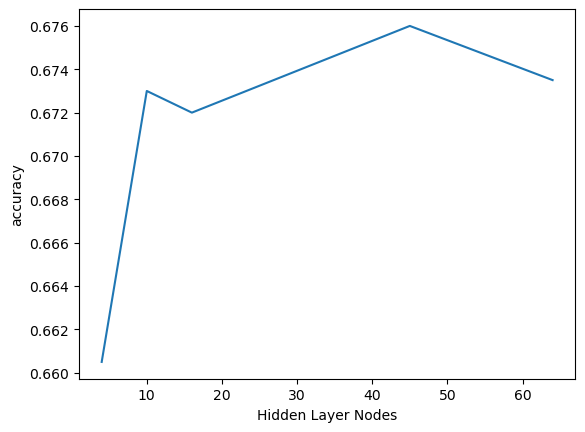

In [179]:
plt.plot(
    mlp_cl_params['hidden_layer_sizes'],
    neural_avg_scores)
plt.xlabel("Hidden Layer Nodes")
plt.ylabel("accuracy")
plt.show()

## Архитектура модели

In [180]:
print("Число слоев (включая входной и выходной):", mlp_cl.n_layers_)
print("Число выходных классов:", mlp_cl.n_outputs_)
print("Форма каждого слоя:")
for i, (w, b) in enumerate(zip(mlp_cl.coefs_, mlp_cl.intercepts_)):
    print(f"  Слой {i}: входы = {w.shape[0]}, выходы = {w.shape[1]}")

Число слоев (включая входной и выходной): 3
Число выходных классов: 1
Форма каждого слоя:
  Слой 0: входы = 2, выходы = 45
  Слой 1: входы = 45, выходы = 1


In [181]:
mlp_cl_epochs = 1000

In [184]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [185]:
y_pred_mlp_cl = mlp_cl.predict(X_cl_test)
mlp_cl_acc = accuracy_score(y_cl_test, y_pred_mlp_cl)
mlp_cl_prec = precision_score(y_cl_test, y_pred_mlp_cl)
mlp_cl_rec = recall_score(y_cl_test, y_pred_mlp_cl)

In [192]:
print(f"accuracy: {mlp_cl_acc:.2f}")
print(f"precision: {mlp_cl_prec:.2f}")
print(f"recall: {mlp_cl_rec:.2f}")

accuracy: 0.66
precision: 0.36
recall: 0.02


In [203]:
y_pred_mlp_cl_train = mlp_cl.predict(X_cl_train)
mlp_cl_mse_train = accuracy_score(y_cl_train, y_pred_mlp_cl_train)
mlp_cl_mae_train = precision_score(y_cl_train, y_pred_mlp_cl_train)
mlp_cl_r2_train = recall_score(y_cl_train, y_pred_mlp_cl_train)

In [206]:
print(f"accuracy: {mlp_cl_mse_train:.2f}")
print(f"precision: {mlp_cl_mae_train:.2f}")
print(f"recall: {mlp_cl_r2_train:.2f}")

accuracy: 0.50
precision: 0.54
recall: 0.02


### Optuna

In [193]:
import optuna
from sklearn.model_selection import cross_val_score

In [194]:
def objective(trial):
    hidden_layer_sizes = tuple([trial.suggest_int("n_units_l{}".format(i), 10, 100) for i in range(trial.suggest_int("n_layers", 1, 3))])
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-4, 1e-1, log=True)
    alpha = trial.suggest_float("alpha", 1e-5, 1e-1, log=True)
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "logistic"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])

    model = MLPClassifier(
        solver="sgd",
        learning_rate_init=learning_rate_init,
        hidden_layer_sizes=hidden_layer_sizes,
        alpha=alpha,
        activation=activation,
        batch_size=batch_size,
        max_iter=1000,
        random_state=42
    )

    score = cross_val_score(model, X_cl_train[:2000], y_cl_train[:2000], cv=3, scoring="accuracy")
    return np.mean(score)

In [195]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

[I 2025-05-29 19:32:45,004] A new study created in memory with name: no-name-bb4dcbf5-e8b8-49f4-b02a-7ae7aceee222
[I 2025-05-29 19:32:46,157] Trial 0 finished with value: 0.6634888261574918 and parameters: {'n_layers': 1, 'n_units_l0': 42, 'learning_rate_init': 0.0433438944574096, 'alpha': 0.07718445028289737, 'activation': 'logistic', 'batch_size': 32}. Best is trial 0 with value: 0.6634888261574918.
[I 2025-05-29 19:32:48,693] Trial 1 finished with value: 0.6680030855443149 and parameters: {'n_layers': 3, 'n_units_l0': 85, 'n_units_l1': 15, 'n_units_l2': 64, 'learning_rate_init': 0.0007894222792444158, 'alpha': 0.00032876277956317787, 'activation': 'tanh', 'batch_size': 128}. Best is trial 0 with value: 0.6634888261574918.
[I 2025-05-29 19:33:00,655] Trial 2 finished with value: 0.6744998371685028 and parameters: {'n_layers': 3, 'n_units_l0': 58, 'n_units_l1': 84, 'n_units_l2': 51, 'learning_rate_init': 0.04241154675505289, 'alpha': 0.005462920214270743, 'activation': 'tanh', 'batch_

In [196]:
print("Лучшие параметры:", study.best_params)
print("Лучшая ошибка:", study.best_value)

Лучшие параметры: {'n_layers': 1, 'n_units_l0': 35, 'learning_rate_init': 0.00015767361988568742, 'alpha': 0.0004827958479974002, 'activation': 'relu', 'batch_size': 128}
Лучшая ошибка: 0.33499691595643616


In [197]:
from sklearn.neural_network import MLPClassifier

best_params = study.best_params.copy()

n_layers = sum(k.startswith("n_units_l") for k in best_params)
hidden_layer_sizes = tuple(best_params[f"n_units_l{i}"] for i in range(n_layers))

final_model_optuna = MLPClassifier(
    solver="sgd",
    learning_rate_init=best_params["learning_rate_init"],
    hidden_layer_sizes=hidden_layer_sizes,
    alpha=best_params["alpha"],
    activation=best_params["activation"],
    batch_size=best_params["batch_size"],
    max_iter=1000,
    random_state=42
)

final_model_optuna.fit(X_cl_train[:2000], y_cl_train[:2000])

MLPClassifier(alpha=0.0004827958479974002, batch_size=128,
              hidden_layer_sizes=(35,),
              learning_rate_init=0.00015767361988568742, max_iter=1000,
              random_state=42, solver='sgd')

In [201]:
y_pred = final_model_optuna.predict(X_cl_test)
mse = accuracy_score(y_cl_test, y_pred)
mae = precision_score(y_cl_test, y_pred)
r2 = recall_score(y_cl_test, y_pred)

In [202]:
print(f"accuracy: {mse:.2f}")
print(f"precision: {mae:.2f}")
print(f"recall:  {r2:.2f}")

accuracy: 0.64
precision: 0.39
recall:  0.11


In [209]:
y_pred = final_model_optuna.predict(X_cl_train)
mse = accuracy_score(y_cl_train, y_pred)
mae = precision_score(y_cl_train, y_pred)
r2 = recall_score(y_cl_train, y_pred)

In [210]:
print(f"accuracy: {mse:.2f}")
print(f"precision: {mae:.2f}")
print(f"recall:  {r2:.2f}")

accuracy: 0.51
precision: 0.55
recall:  0.11


### Hyperopt

In [211]:
import hyperopt

In [212]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK


space = {
    'hidden_layer_sizes': hp.choice('hidden_layer_sizes', [
        (50,), (100,), (50, 50), (100, 50), (100, 100)
    ]),
    'learning_rate_init': hp.loguniform('learning_rate_init', np.log(1e-4), np.log(1e-1)),
    'alpha': hp.loguniform('alpha', np.log(1e-5), np.log(1e-1)),
    'activation': hp.choice('activation', ['relu', 'tanh', 'logistic']),
    'batch_size': hp.choice('batch_size', [16, 32, 64, 128]),
}

def objective(params):
    model = MLPClassifier(
        solver='sgd',
        max_iter=1000,
        random_state=42,
        **params
    )
    score = cross_val_score(model, X_cl_train[:2000], y_cl_train[:2000], cv=3, scoring='accuracy')
    return {
        'loss': np.mean(score),  
        'status': STATUS_OK
    }

In [213]:
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials,
)

 96%|██████████████████████████████████████████████  | 48/50 [04:03<00:18,  9.17s/trial, best loss: 0.4414421918170044]

C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



100%|████████████████████████████████████████████████| 50/50 [04:12<00:00,  5.06s/trial, best loss: 0.4414421918170044]


In [214]:
print("Лучшие параметры:", best_params)

Лучшие параметры: {'n_layers': 1, 'n_units_l0': 35, 'learning_rate_init': 0.00015767361988568742, 'alpha': 0.0004827958479974002, 'activation': 'relu', 'batch_size': 128}


In [219]:
mlp_hyperopt_cl = MLPClassifier(
    solver='sgd',
    batch_size=128,
    activation='relu',
    alpha=0.0004827958479974002,
    max_iter=1000,
    random_state=42
).fit(X_cl_train, y_cl_train)

In [220]:
y_pred = mlp_hyperopt_cl.predict(X_cl_test)
mse = accuracy_score(y_cl_test, y_pred)
mae = precision_score(y_cl_test, y_pred)
r2 = recall_score(y_cl_test, y_pred)
print(f"accuracy: {mse:.2f}")
print(f"precision: {mae:.2f}")
print(f"recall:  {r2:.2f}")

accuracy: 0.34
precision: 0.34
recall:  1.00


In [223]:
y_pred = mlp_hyperopt_cl.predict(X_cl_train)
mse = accuracy_score(y_cl_train, y_pred)
mae = precision_score(y_cl_train, y_pred)
r2 = recall_score(y_cl_train, y_pred)
print(f"accuracy: {mse:.2f}")
print(f"precision: {mae:.2f}")
print(f"recall:  {r2:.2f}")

accuracy: 0.50
precision: 0.50
recall:  1.00


### Adam

In [238]:
max_iters = np.arange(100, 2001, 200)
mae_scores = []

for max_iter in max_iters:
    model = MLPClassifier(
        solver='adam',
        max_iter=max_iter,
        activation='tanh',
        hidden_layer_sizes=64,
        random_state=42
    )
    model.fit(X_cl_train[:5000], y_cl_train[:5000])
    y_pred = model.predict(X_cl_test)
    accuracy = accuracy_score(y_cl_test, y_pred)
    mae_scores.append(accuracy)

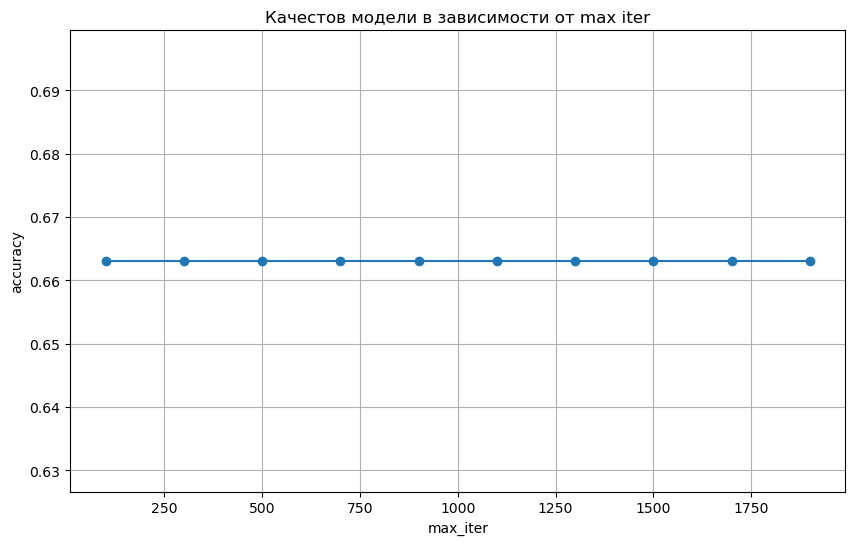

In [239]:
plt.figure(figsize=(10, 6))
plt.plot(max_iters, mae_scores, marker='o')
plt.title("Качестов модели в зависимости от max iter")
plt.xlabel("max_iter")
plt.ylabel("accuracy")
plt.grid(True)
plt.show()

In [242]:
mlp_cl_adam = MLPClassifier(
    solver='adam',
    max_iter=10000,
    activation='tanh',
    hidden_layer_sizes=64
).fit(X_cl_train, y_cl_train)

In [243]:
y_pred = mlp_cl_adam.predict(X_cl_test)
mse = accuracy_score(y_cl_test, y_pred)
mae = precision_score(y_cl_test, y_pred)
r2 = recall_score(y_cl_test, y_pred)
print(f"accuracy: {mse:.2f}")
print(f"precision: {mae:.2f}")
print(f"recall:  {r2:.2f}")

accuracy: 0.51
precision: 0.37
recall:  0.65


In [244]:
y_pred = mlp_cl_adam.predict(X_cl_train)
mse = accuracy_score(y_cl_train, y_pred)
mae = precision_score(y_cl_train, y_pred)
r2 = recall_score(y_cl_train, y_pred)
print(f"accuracy: {mse:.2f}")
print(f"precision: {mae:.2f}")
print(f"recall:  {r2:.2f}")

accuracy: 0.55
precision: 0.54
recall:  0.65


### lbfgs

In [251]:
mlp_cl_lbfgs = MLPClassifier(
    solver='lbfgs',
    max_iter=1000,
    activation='tanh',
    hidden_layer_sizes=64
).fit(X_cl_train, y_cl_train)

C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [252]:
y_pred = mlp_cl_lbfgs.predict(X_cl_test)
mse = accuracy_score(y_cl_test, y_pred)
mae = precision_score(y_cl_test, y_pred)
r2 = recall_score(y_cl_test, y_pred)
print(f"accuracy: {mse:.2f}")
print(f"precision: {mae:.2f}")
print(f"recall:  {r2:.2f}")

accuracy: 0.55
precision: 0.39
recall:  0.62


In [253]:
y_pred = mlp_cl_lbfgs.predict(X_cl_train)
mse = accuracy_score(y_cl_train, y_pred)
mae = precision_score(y_cl_train, y_pred)
r2 = recall_score(y_cl_train, y_pred)
print(f"accuracy: {mse:.2f}")
print(f"precision: {mae:.2f}")
print(f"recall:  {r2:.2f}")

accuracy: 0.56
precision: 0.56
recall:  0.62


# Итоговые результаты по Sklearn

In [265]:
import pandas as pd

columns = [
    "Регрессор/Фреймворк",

    "Test R²", "Test MSE", "Test MAE", "Test Кол-во эпох", "Test Оптимизатор",
    "Train R²", "Train MSE", "Train MAE", "Train Кол-во эпох", "Train Оптимизатор"
]

data = [
    ["MLPRegressor", 0.51, 79621.76, 210.61, 1000, "RandomSearch SGD", 0.52, 79427.66, 210.29, 1000, "RandomSearch SGD"],
    ["MLPRegressor", 0.52, 79477.33, 212.06, 1000, "Optuna SGD", 0.52, 79496.83, 211.90, 1000, "Optuna SGD"],
    ["MLPRegressor", 0.51, 80788.13, 215.96, 10000, "Hyperopt SGD", 0.51, 80587.98, 215.71, 10000, "Hyperopt SGD"],
    ["MLPRegressor", 0.52, 78617.52, 208.04, 10000, "Adam", 0.52, 78497.76, 207.90, 10000, "Adam"],
    ["MLPRegressor", 0.51, 80827.78, 211.26, 10000, "lbfgs", 0.52, 80543.81, 210.29, 10000, "lbfgs"]
]

df = pd.DataFrame(data, columns=columns)

In [266]:
df

,Регрессор/Фреймворк,Test R²,Test MSE,Test MAE,Test Кол-во эпох,Test Оптимизатор,Train R²,Train MSE,Train MAE,Train Кол-во эпох,Train Оптимизатор
0,MLPRegressor,0.51,79621.76,210.61,1000,RandomSearch SGD,0.52,79427.66,210.29,1000,RandomSearch SGD
1,MLPRegressor,0.52,79477.33,212.06,1000,Optuna SGD,0.52,79496.83,211.90,1000,Optuna SGD
2,MLPRegressor,0.51,80788.13,215.96,10000,Hyperopt SGD,0.51,80587.98,215.71,10000,Hyperopt SGD
3,MLPRegressor,0.52,78617.52,208.04,10000,Adam,0.52,78497.76,207.90,10000,Adam
4,MLPRegressor,0.51,80827.78,211.26,10000,lbfgs,0.52,80543.81,210.29,10000,lbfgs


In [267]:
columns = [
    "Регрессор/Фреймворк",

    "Test accuracy", "Test precision", "Test recall", "Test Кол-во эпох", "Test Оптимизатор",
    "Train accuracy", "Train precision", "Train recall", "Train Кол-во эпох", "Train Оптимизатор"
]

data = [
    ["MLPClassifier", 0.66, 0.36, 0.02, 1000, "RandomSearch SGD", 0.50, 0.54, 0.02, 1000, "RandomSearch SGD"],
    ["MLPClassifier", 0.64, 0.39, 0.11, 1000, "Optuna SGD", 0.51, 0.55, 0.11, 1000, "Optuna SGD"],
    ["MLPClassifier", 0.34, 0.34, 1.00, 10000, "Hyperopt SGD", 0.50, 0.50, 1.00, 10000, "Hyperopt SGD"],
    ["MLPClassifier", 0.51, 0.37, 0.65, 10000, "Adam", 0.55, 0.54, 0.65, 10000, "Adam"],
    ["MLPClassifier", 0.55, 0.39, 0.62, 10000, "lbfgs", 0.56, 0.56, 0.62, 10000, "lbfgs"]
]

df2 = pd.DataFrame(data, columns=columns)

In [268]:
df2

,Регрессор/Фреймворк,Test accuracy,Test precision,Test recall,Test Кол-во эпох,Test Оптимизатор,Train accuracy,Train precision,Train recall,Train Кол-во эпох,Train Оптимизатор
0,MLPClassifier,0.66,0.36,0.02,1000,RandomSearch SGD,0.50,0.54,0.02,1000,RandomSearch SGD
1,MLPClassifier,0.64,0.39,0.11,1000,Optuna SGD,0.51,0.55,0.11,1000,Optuna SGD
2,MLPClassifier,0.34,0.34,1.00,10000,Hyperopt SGD,0.50,0.50,1.00,10000,Hyperopt SGD
3,MLPClassifier,0.51,0.37,0.65,10000,Adam,0.55,0.54,0.65,10000,Adam
4,MLPClassifier,0.55,0.39,0.62,10000,lbfgs,0.56,0.56,0.62,10000,lbfgs


# Tensor Flow

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, RMSprop

# Регрессия

## Optuna

In [281]:
def objective(trial):
    n_layers = trial.suggest_int("n_layers", 1, 3)
    units = trial.suggest_int("units", 32, 128, step=32)
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "rmsprop"])
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    if optimizer_name == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)


    model = Sequential()
    model.add(Dense(units, activation=activation, input_shape=(X_reg_train.shape[1],)))
    for _ in range(n_layers - 1):
        model.add(Dense(units, activation=activation))
    model.add(Dense(1))  

    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])


    history = model.fit(
        X_reg_train[:2000], y_reg_train[:2000],
        validation_data=(X_reg_test, y_reg_test),
        batch_size=batch_size,
        epochs=5,
        verbose=1
    )

    val_mse = min(history.history["val_loss"])
    return val_mse  

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2025-05-29 21:41:59,295] A new study created in memory with name: no-name-3e027dd3-b5ed-458a-8bb9-b42e87890fdf


Epoch 1/5
32/32 [==============================] - 7s 185ms/step - loss: 602122.3125 - mae: 668.4885 - val_loss: 627612.0000 - val_mae: 680.9246
Epoch 2/5
32/32 [==============================] - 5s 177ms/step - loss: 601715.9375 - mae: 668.2095 - val_loss: 627212.2500 - val_mae: 680.6577
Epoch 3/5
32/32 [==============================] - 6s 179ms/step - loss: 601322.0000 - mae: 667.9432 - val_loss: 626806.8750 - val_mae: 680.3867
Epoch 4/5
32/32 [==============================] - 5s 177ms/step - loss: 600912.0000 - mae: 667.6658 - val_loss: 626373.9375 - val_mae: 680.1011
Epoch 5/5
32/32 [==============================] - 6s 181ms/step - loss: 600477.3125 - mae: 667.3741 - val_loss: 625925.0000 - val_mae: 679.8053


[I 2025-05-29 21:42:28,216] Trial 0 finished with value: 625925.0 and parameters: {'n_layers': 1, 'units': 128, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0003962118674209325, 'batch_size': 64}. Best is trial 0 with value: 625925.0.


Epoch 1/5
63/63 [==============================] - 13s 204ms/step - loss: 158780.0469 - mae: 287.3879 - val_loss: 96122.1094 - val_mae: 221.7542
Epoch 2/5
63/63 [==============================] - 12s 196ms/step - loss: 86264.8984 - mae: 219.4304 - val_loss: 90264.5469 - val_mae: 232.9502
Epoch 3/5
63/63 [==============================] - 12s 196ms/step - loss: 84567.7344 - mae: 216.6440 - val_loss: 85640.3359 - val_mae: 213.2366
Epoch 4/5
63/63 [==============================] - 12s 194ms/step - loss: 82346.0078 - mae: 213.7039 - val_loss: 112287.7266 - val_mae: 232.1929
Epoch 5/5
63/63 [==============================] - 12s 195ms/step - loss: 83364.7656 - mae: 215.8800 - val_loss: 86039.6719 - val_mae: 211.3022


[I 2025-05-29 21:43:30,328] Trial 1 finished with value: 85640.3359375 and parameters: {'n_layers': 3, 'units': 128, 'activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.005951717008115836, 'batch_size': 32}. Best is trial 1 with value: 85640.3359375.


Epoch 1/5
125/125 [==============================] - 25s 196ms/step - loss: 576036.2500 - mae: 648.8870 - val_loss: 585070.5000 - val_mae: 649.0063
Epoch 2/5
125/125 [==============================] - 24s 192ms/step - loss: 546148.1250 - mae: 625.2973 - val_loss: 556261.6875 - val_mae: 626.5669
Epoch 3/5
125/125 [==============================] - 24s 191ms/step - loss: 518304.9062 - mae: 602.7459 - val_loss: 528468.1250 - val_mae: 604.2823
Epoch 4/5
125/125 [==============================] - 24s 194ms/step - loss: 491595.3125 - mae: 580.3674 - val_loss: 501669.4375 - val_mae: 582.1348
Epoch 5/5
125/125 [==============================] - 24s 193ms/step - loss: 465885.7500 - mae: 558.3209 - val_loss: 475919.8125 - val_mae: 560.3058


[I 2025-05-29 21:45:31,170] Trial 2 finished with value: 475919.8125 and parameters: {'n_layers': 3, 'units': 32, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.005581753668322992, 'batch_size': 16}. Best is trial 1 with value: 85640.3359375.


Epoch 1/5
63/63 [==============================] - 12s 190ms/step - loss: 601069.9375 - mae: 668.2975 - val_loss: 625628.5000 - val_mae: 680.5283
Epoch 2/5
63/63 [==============================] - 11s 183ms/step - loss: 598860.2500 - mae: 667.5550 - val_loss: 622874.4375 - val_mae: 679.4000
Epoch 3/5
63/63 [==============================] - 11s 179ms/step - loss: 595869.9375 - mae: 666.0880 - val_loss: 619457.3750 - val_mae: 677.5221
Epoch 4/5
63/63 [==============================] - 11s 183ms/step - loss: 592148.0625 - mae: 663.6989 - val_loss: 615142.1250 - val_mae: 674.5348
Epoch 5/5
63/63 [==============================] - 11s 182ms/step - loss: 587408.9375 - mae: 660.0704 - val_loss: 609811.2500 - val_mae: 670.2509


[I 2025-05-29 21:46:28,894] Trial 3 finished with value: 609811.25 and parameters: {'n_layers': 2, 'units': 96, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0002922652848297819, 'batch_size': 32}. Best is trial 1 with value: 85640.3359375.


Epoch 1/5
32/32 [==============================] - 7s 210ms/step - loss: 600429.6875 - mae: 667.9137 - val_loss: 624144.5000 - val_mae: 679.3817
Epoch 2/5
32/32 [==============================] - 6s 190ms/step - loss: 596104.7500 - mae: 664.8739 - val_loss: 618640.2500 - val_mae: 674.8959
Epoch 3/5
32/32 [==============================] - 6s 194ms/step - loss: 591046.2500 - mae: 660.4696 - val_loss: 614661.9375 - val_mae: 671.4609
Epoch 4/5
32/32 [==============================] - 6s 199ms/step - loss: 588153.8750 - mae: 658.0024 - val_loss: 612562.6875 - val_mae: 669.7877
Epoch 5/5
32/32 [==============================] - 6s 195ms/step - loss: 586384.1250 - mae: 656.6065 - val_loss: 610985.9375 - val_mae: 668.5939


[I 2025-05-29 21:47:00,613] Trial 4 finished with value: 610985.9375 and parameters: {'n_layers': 3, 'units': 32, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0010250493599983273, 'batch_size': 64}. Best is trial 1 with value: 85640.3359375.


Epoch 1/5
63/63 [==============================] - 12s 191ms/step - loss: 602438.0000 - mae: 668.5938 - val_loss: 628047.8750 - val_mae: 681.1032
Epoch 2/5
63/63 [==============================] - 12s 186ms/step - loss: 602218.1875 - mae: 668.4335 - val_loss: 627829.1250 - val_mae: 680.9452
Epoch 3/5
63/63 [==============================] - 11s 185ms/step - loss: 601999.6250 - mae: 668.2687 - val_loss: 627603.9375 - val_mae: 680.7781
Epoch 4/5
63/63 [==============================] - 12s 187ms/step - loss: 601766.8750 - mae: 668.0922 - val_loss: 627359.0625 - val_mae: 680.5935
Epoch 5/5
63/63 [==============================] - 11s 181ms/step - loss: 601509.5625 - mae: 667.8967 - val_loss: 627083.3750 - val_mae: 680.3870


[I 2025-05-29 21:47:59,081] Trial 5 finished with value: 627083.375 and parameters: {'n_layers': 2, 'units': 32, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.00010909721146528874, 'batch_size': 32}. Best is trial 1 with value: 85640.3359375.


Epoch 1/5
63/63 [==============================] - 12s 186ms/step - loss: 587339.8750 - mae: 659.3297 - val_loss: 594715.5000 - val_mae: 657.1177
Epoch 2/5
63/63 [==============================] - 11s 179ms/step - loss: 560500.9375 - mae: 636.8212 - val_loss: 577205.1875 - val_mae: 642.9620
Epoch 3/5
63/63 [==============================] - 11s 180ms/step - loss: 545625.5000 - mae: 624.8770 - val_loss: 562997.6875 - val_mae: 631.8743
Epoch 4/5
63/63 [==============================] - 11s 182ms/step - loss: 531732.9375 - mae: 613.7782 - val_loss: 548985.6875 - val_mae: 620.7976
Epoch 5/5
63/63 [==============================] - 11s 179ms/step - loss: 518281.6562 - mae: 602.7296 - val_loss: 535355.6250 - val_mae: 609.8668


[I 2025-05-29 21:48:56,256] Trial 6 finished with value: 535355.625 and parameters: {'n_layers': 2, 'units': 96, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0018366272021433502, 'batch_size': 32}. Best is trial 1 with value: 85640.3359375.


Epoch 1/5
125/125 [==============================] - 25s 195ms/step - loss: 588766.4375 - mae: 658.5320 - val_loss: 562187.7500 - val_mae: 631.6955
Epoch 2/5
125/125 [==============================] - 23s 189ms/step - loss: 323042.8125 - mae: 436.7300 - val_loss: 137509.1406 - val_mae: 277.1581
Epoch 3/5
125/125 [==============================] - 23s 184ms/step - loss: 110444.7266 - mae: 248.8317 - val_loss: 107239.1484 - val_mae: 244.0428
Epoch 4/5
125/125 [==============================] - 23s 187ms/step - loss: 96991.6406 - mae: 233.2139 - val_loss: 99440.2266 - val_mae: 235.7103
Epoch 5/5
125/125 [==============================] - 24s 193ms/step - loss: 91271.5312 - mae: 227.0083 - val_loss: 94821.1016 - val_mae: 229.4965


[I 2025-05-29 21:50:54,561] Trial 7 finished with value: 94821.1015625 and parameters: {'n_layers': 3, 'units': 32, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0009665235471474989, 'batch_size': 16}. Best is trial 1 with value: 85640.3359375.


Epoch 1/5
125/125 [==============================] - 25s 193ms/step - loss: 581896.6250 - mae: 653.2598 - val_loss: 591919.0000 - val_mae: 654.2321
Epoch 2/5
125/125 [==============================] - 23s 189ms/step - loss: 554566.8750 - mae: 632.1420 - val_loss: 567188.8125 - val_mae: 635.1666
Epoch 3/5
125/125 [==============================] - 23s 189ms/step - loss: 530996.9375 - mae: 613.1536 - val_loss: 543388.2500 - val_mae: 616.3071
Epoch 4/5
125/125 [==============================] - 23s 188ms/step - loss: 507928.1875 - mae: 594.3014 - val_loss: 520268.1562 - val_mae: 597.5396
Epoch 5/5
125/125 [==============================] - 23s 188ms/step - loss: 485832.6875 - mae: 575.4893 - val_loss: 497958.2188 - val_mae: 579.0307


[I 2025-05-29 21:52:52,910] Trial 8 finished with value: 497958.21875 and parameters: {'n_layers': 2, 'units': 32, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0046942514946433315, 'batch_size': 16}. Best is trial 1 with value: 85640.3359375.


Epoch 1/5
125/125 [==============================] - 41s 324ms/step - loss: 293442.1875 - mae: 408.4756 - val_loss: 108111.9844 - val_mae: 243.7685
Epoch 2/5
125/125 [==============================] - 24s 193ms/step - loss: 90498.8203 - mae: 226.0423 - val_loss: 91885.4297 - val_mae: 221.1721
Epoch 3/5
125/125 [==============================] - 23s 189ms/step - loss: 83473.8047 - mae: 216.2332 - val_loss: 86937.3828 - val_mae: 220.7786
Epoch 4/5
125/125 [==============================] - 24s 191ms/step - loss: 82270.7109 - mae: 215.8277 - val_loss: 86545.5781 - val_mae: 214.4162
Epoch 5/5
125/125 [==============================] - 24s 197ms/step - loss: 81933.0391 - mae: 213.5115 - val_loss: 86851.3750 - val_mae: 230.9836


[I 2025-05-29 21:55:09,307] Trial 9 finished with value: 86545.578125 and parameters: {'n_layers': 3, 'units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0018626368864594017, 'batch_size': 16}. Best is trial 1 with value: 85640.3359375.


Epoch 1/5
63/63 [==============================] - 12s 189ms/step - loss: 583372.5625 - mae: 655.8763 - val_loss: 568359.2500 - val_mae: 641.3599
Epoch 2/5
63/63 [==============================] - 11s 179ms/step - loss: 455026.6875 - mae: 564.7451 - val_loss: 358964.9062 - val_mae: 489.7835
Epoch 3/5
63/63 [==============================] - 11s 178ms/step - loss: 233610.4375 - mae: 376.0303 - val_loss: 155353.6094 - val_mae: 286.6087
Epoch 4/5
63/63 [==============================] - 11s 178ms/step - loss: 110224.9844 - mae: 237.4222 - val_loss: 95990.6641 - val_mae: 220.0810
Epoch 5/5
63/63 [==============================] - 11s 172ms/step - loss: 84749.5469 - mae: 211.3918 - val_loss: 87904.4375 - val_mae: 218.8265


[I 2025-05-29 21:56:05,481] Trial 10 finished with value: 87904.4375 and parameters: {'n_layers': 1, 'units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.00822413841361413, 'batch_size': 32}. Best is trial 1 with value: 85640.3359375.


Epoch 1/5
125/125 [==============================] - 24s 192ms/step - loss: 242483.0938 - mae: 366.3514 - val_loss: 100155.6328 - val_mae: 240.5067
Epoch 2/5
125/125 [==============================] - 24s 191ms/step - loss: 86553.2578 - mae: 220.4384 - val_loss: 88545.9453 - val_mae: 226.9993
Epoch 3/5
125/125 [==============================] - 24s 192ms/step - loss: 82606.3672 - mae: 214.8053 - val_loss: 85554.1562 - val_mae: 220.8524
Epoch 4/5
125/125 [==============================] - 23s 188ms/step - loss: 81485.4297 - mae: 214.1485 - val_loss: 85707.6797 - val_mae: 215.0768
Epoch 5/5
125/125 [==============================] - 23s 187ms/step - loss: 82832.6562 - mae: 212.9982 - val_loss: 85234.7578 - val_mae: 221.5579


[I 2025-05-29 21:58:04,047] Trial 11 finished with value: 85234.7578125 and parameters: {'n_layers': 3, 'units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0027051376815552196, 'batch_size': 16}. Best is trial 11 with value: 85234.7578125.


Epoch 1/5
125/125 [==============================] - 35s 279ms/step - loss: 253071.5625 - mae: 375.2468 - val_loss: 98628.1250 - val_mae: 233.5633
Epoch 2/5
125/125 [==============================] - 44s 355ms/step - loss: 86499.5703 - mae: 220.1891 - val_loss: 87718.2188 - val_mae: 222.7130
Epoch 3/5
125/125 [==============================] - 23s 189ms/step - loss: 81988.3672 - mae: 214.5451 - val_loss: 86193.7969 - val_mae: 217.8091
Epoch 4/5
125/125 [==============================] - 23s 188ms/step - loss: 81093.0781 - mae: 213.3408 - val_loss: 85119.2109 - val_mae: 219.8323
Epoch 5/5
125/125 [==============================] - 23s 189ms/step - loss: 82825.5859 - mae: 216.1931 - val_loss: 85052.7734 - val_mae: 221.6840


[I 2025-05-29 22:00:33,627] Trial 12 finished with value: 85052.7734375 and parameters: {'n_layers': 3, 'units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0029213171162170474, 'batch_size': 16}. Best is trial 12 with value: 85052.7734375.


Epoch 1/5
125/125 [==============================] - 24s 191ms/step - loss: 297514.1875 - mae: 413.5819 - val_loss: 107738.6484 - val_mae: 246.8929
Epoch 2/5
125/125 [==============================] - 23s 188ms/step - loss: 90311.3516 - mae: 225.3779 - val_loss: 92508.8047 - val_mae: 222.2192
Epoch 3/5
125/125 [==============================] - 23s 186ms/step - loss: 83194.7344 - mae: 216.4095 - val_loss: 86239.4688 - val_mae: 219.3485
Epoch 4/5
125/125 [==============================] - 23s 184ms/step - loss: 82039.9688 - mae: 214.6369 - val_loss: 85263.2656 - val_mae: 217.4287
Epoch 5/5
125/125 [==============================] - 23s 185ms/step - loss: 80431.6484 - mae: 211.8360 - val_loss: 84892.3594 - val_mae: 219.5874


[I 2025-05-29 22:02:30,228] Trial 13 finished with value: 84892.359375 and parameters: {'n_layers': 3, 'units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.002341894127004706, 'batch_size': 16}. Best is trial 13 with value: 84892.359375.


Epoch 1/5
125/125 [==============================] - 24s 192ms/step - loss: 310452.7812 - mae: 422.5113 - val_loss: 110154.3125 - val_mae: 241.5222
Epoch 2/5
125/125 [==============================] - 23s 184ms/step - loss: 89885.4766 - mae: 224.1459 - val_loss: 88901.2578 - val_mae: 221.2622
Epoch 3/5
125/125 [==============================] - 23s 186ms/step - loss: 82516.2109 - mae: 214.6476 - val_loss: 86713.1719 - val_mae: 222.8783
Epoch 4/5
125/125 [==============================] - 23s 188ms/step - loss: 82037.8047 - mae: 215.0478 - val_loss: 87105.3594 - val_mae: 217.4320
Epoch 5/5
125/125 [==============================] - 24s 191ms/step - loss: 81527.0938 - mae: 214.3080 - val_loss: 85524.3281 - val_mae: 223.1917


[I 2025-05-29 22:04:27,654] Trial 14 finished with value: 85524.328125 and parameters: {'n_layers': 3, 'units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.003009993689018958, 'batch_size': 16}. Best is trial 13 with value: 84892.359375.


Epoch 1/5
125/125 [==============================] - 23s 184ms/step - loss: 584038.7500 - mae: 655.8921 - val_loss: 557646.1250 - val_mae: 632.4026
Epoch 2/5
125/125 [==============================] - 23s 184ms/step - loss: 375293.1875 - mae: 493.8997 - val_loss: 207683.4688 - val_mae: 337.7306
Epoch 3/5
125/125 [==============================] - 23s 185ms/step - loss: 119668.7500 - mae: 252.4518 - val_loss: 100731.8750 - val_mae: 235.5767
Epoch 4/5
125/125 [==============================] - 23s 185ms/step - loss: 91505.4609 - mae: 226.2010 - val_loss: 94259.8984 - val_mae: 229.5906
Epoch 5/5
125/125 [==============================] - 22s 181ms/step - loss: 86952.8281 - mae: 221.2847 - val_loss: 90884.3516 - val_mae: 225.7444


[I 2025-05-29 22:06:22,245] Trial 15 finished with value: 90884.3515625 and parameters: {'n_layers': 2, 'units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0009866429751813287, 'batch_size': 16}. Best is trial 13 with value: 84892.359375.


Epoch 1/5
125/125 [==============================] - 25s 196ms/step - loss: 592459.6875 - mae: 661.2313 - val_loss: 582791.4375 - val_mae: 648.6562
Epoch 2/5
125/125 [==============================] - 24s 193ms/step - loss: 389259.0000 - mae: 498.3607 - val_loss: 192259.2969 - val_mae: 324.9807
Epoch 3/5
125/125 [==============================] - 24s 194ms/step - loss: 128441.6406 - mae: 268.9454 - val_loss: 119595.8438 - val_mae: 257.2762
Epoch 4/5
125/125 [==============================] - 24s 193ms/step - loss: 107302.3359 - mae: 244.3768 - val_loss: 108610.8828 - val_mae: 245.0818
Epoch 5/5
125/125 [==============================] - 24s 191ms/step - loss: 99348.4766 - mae: 235.4381 - val_loss: 101766.8906 - val_mae: 238.2593


[I 2025-05-29 22:08:22,903] Trial 16 finished with value: 101766.890625 and parameters: {'n_layers': 3, 'units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0005124832998281251, 'batch_size': 16}. Best is trial 13 with value: 84892.359375.


Epoch 1/5
32/32 [==============================] - 6s 188ms/step - loss: 601610.8750 - mae: 668.0793 - val_loss: 626386.9375 - val_mae: 680.0593
Epoch 2/5
32/32 [==============================] - 6s 177ms/step - loss: 599632.3750 - mae: 666.7600 - val_loss: 623861.9375 - val_mae: 678.4224
Epoch 3/5
32/32 [==============================] - 6s 178ms/step - loss: 596399.9375 - mae: 664.6448 - val_loss: 619571.6250 - val_mae: 675.6696
Epoch 4/5
32/32 [==============================] - 5s 172ms/step - loss: 591154.9375 - mae: 661.2042 - val_loss: 612908.3750 - val_mae: 671.4346
Epoch 5/5
32/32 [==============================] - 5s 173ms/step - loss: 583381.1875 - mae: 656.2153 - val_loss: 603421.0000 - val_mae: 665.4978


[I 2025-05-29 22:08:51,130] Trial 17 finished with value: 603421.0 and parameters: {'n_layers': 1, 'units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.002595167605667096, 'batch_size': 64}. Best is trial 13 with value: 84892.359375.


Epoch 1/5
125/125 [==============================] - 25s 193ms/step - loss: 393535.5938 - mae: 498.3434 - val_loss: 122764.8672 - val_mae: 262.5087
Epoch 2/5
125/125 [==============================] - 24s 192ms/step - loss: 101881.5156 - mae: 238.9680 - val_loss: 97710.3594 - val_mae: 232.0205
Epoch 3/5
125/125 [==============================] - 23s 189ms/step - loss: 88248.9453 - mae: 221.9647 - val_loss: 90927.0703 - val_mae: 223.1875
Epoch 4/5
125/125 [==============================] - 23s 189ms/step - loss: 83604.5547 - mae: 217.3099 - val_loss: 87513.6172 - val_mae: 220.1572
Epoch 5/5
125/125 [==============================] - 24s 194ms/step - loss: 82929.2031 - mae: 215.4731 - val_loss: 87266.6875 - val_mae: 216.8252


[I 2025-05-29 22:10:50,662] Trial 18 finished with value: 87266.6875 and parameters: {'n_layers': 3, 'units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0012768856967997919, 'batch_size': 16}. Best is trial 13 with value: 84892.359375.


Epoch 1/5
125/125 [==============================] - 24s 190ms/step - loss: 218510.2344 - mae: 345.0560 - val_loss: 89731.8047 - val_mae: 220.2062
Epoch 2/5
125/125 [==============================] - 23s 186ms/step - loss: 81691.7500 - mae: 214.6104 - val_loss: 85961.8359 - val_mae: 216.0288
Epoch 3/5
125/125 [==============================] - 22s 180ms/step - loss: 81392.6016 - mae: 213.5149 - val_loss: 86345.0156 - val_mae: 225.3749
Epoch 4/5
125/125 [==============================] - 22s 179ms/step - loss: 81248.2188 - mae: 213.6354 - val_loss: 85892.4609 - val_mae: 223.8524
Epoch 5/5
125/125 [==============================] - 23s 183ms/step - loss: 81385.6797 - mae: 213.5261 - val_loss: 85533.8828 - val_mae: 216.0040


[I 2025-05-29 22:12:45,150] Trial 19 finished with value: 85533.8828125 and parameters: {'n_layers': 2, 'units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.009041554894595471, 'batch_size': 16}. Best is trial 13 with value: 84892.359375.


Epoch 1/5
32/32 [==============================] - 7s 202ms/step - loss: 597392.5625 - mae: 665.0637 - val_loss: 610869.9375 - val_mae: 669.1750
Epoch 2/5
32/32 [==============================] - 6s 184ms/step - loss: 548351.3125 - mae: 629.6658 - val_loss: 504159.9062 - val_mae: 592.9106
Epoch 3/5
32/32 [==============================] - 6s 188ms/step - loss: 374884.7812 - mae: 492.3995 - val_loss: 255378.5000 - val_mae: 384.0430
Epoch 4/5
32/32 [==============================] - 6s 188ms/step - loss: 153399.6875 - mae: 285.9323 - val_loss: 111761.0391 - val_mae: 247.2966
Epoch 5/5
32/32 [==============================] - 6s 188ms/step - loss: 100712.0625 - mae: 238.2541 - val_loss: 101291.0547 - val_mae: 237.0650


[I 2025-05-29 22:13:15,417] Trial 20 finished with value: 101291.0546875 and parameters: {'n_layers': 2, 'units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.003958528537207526, 'batch_size': 64}. Best is trial 13 with value: 84892.359375.


Epoch 1/5
125/125 [==============================] - 25s 196ms/step - loss: 279776.0000 - mae: 394.0398 - val_loss: 105082.8438 - val_mae: 247.2215
Epoch 2/5
125/125 [==============================] - 24s 191ms/step - loss: 89678.6406 - mae: 225.5907 - val_loss: 88794.0234 - val_mae: 223.8844
Epoch 3/5
125/125 [==============================] - 23s 188ms/step - loss: 82695.4141 - mae: 215.8633 - val_loss: 86255.8906 - val_mae: 221.9701
Epoch 4/5
125/125 [==============================] - 24s 192ms/step - loss: 81691.5781 - mae: 213.7431 - val_loss: 85609.5156 - val_mae: 216.0635
Epoch 5/5
125/125 [==============================] - 24s 190ms/step - loss: 80574.2969 - mae: 212.1378 - val_loss: 85641.1172 - val_mae: 218.0658


[I 2025-05-29 22:15:14,784] Trial 21 finished with value: 85609.515625 and parameters: {'n_layers': 3, 'units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.002122840326713098, 'batch_size': 16}. Best is trial 13 with value: 84892.359375.


Epoch 1/5
125/125 [==============================] - 25s 193ms/step - loss: 243911.8906 - mae: 365.0403 - val_loss: 95069.3672 - val_mae: 235.0793
Epoch 2/5
125/125 [==============================] - 24s 190ms/step - loss: 86518.1250 - mae: 220.8956 - val_loss: 87086.6953 - val_mae: 220.9044
Epoch 3/5
125/125 [==============================] - 24s 190ms/step - loss: 81776.8594 - mae: 213.3494 - val_loss: 85721.8359 - val_mae: 217.3934
Epoch 4/5
125/125 [==============================] - 24s 191ms/step - loss: 81529.4062 - mae: 213.2481 - val_loss: 86503.5078 - val_mae: 227.3901
Epoch 5/5
125/125 [==============================] - 24s 192ms/step - loss: 80054.6641 - mae: 212.7546 - val_loss: 85492.1797 - val_mae: 214.5665


[I 2025-05-29 22:17:14,161] Trial 22 finished with value: 85492.1796875 and parameters: {'n_layers': 3, 'units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0035613018798512537, 'batch_size': 16}. Best is trial 13 with value: 84892.359375.


Epoch 1/5
125/125 [==============================] - 25s 198ms/step - loss: 314937.6250 - mae: 428.5478 - val_loss: 112092.1406 - val_mae: 254.4761
Epoch 2/5
125/125 [==============================] - 24s 192ms/step - loss: 93312.1562 - mae: 228.6466 - val_loss: 90845.0000 - val_mae: 227.7088
Epoch 3/5
125/125 [==============================] - 23s 182ms/step - loss: 83667.8750 - mae: 215.9591 - val_loss: 88214.9766 - val_mae: 228.2021
Epoch 4/5
125/125 [==============================] - 24s 193ms/step - loss: 81799.7734 - mae: 214.0910 - val_loss: 88974.2266 - val_mae: 218.0448
Epoch 5/5
125/125 [==============================] - 24s 194ms/step - loss: 80204.1016 - mae: 211.4320 - val_loss: 91981.9375 - val_mae: 218.4147


[I 2025-05-29 22:19:14,000] Trial 23 finished with value: 88214.9765625 and parameters: {'n_layers': 3, 'units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0016094457950334617, 'batch_size': 16}. Best is trial 13 with value: 84892.359375.


Epoch 1/5
125/125 [==============================] - 25s 198ms/step - loss: 549839.8750 - mae: 628.2315 - val_loss: 360505.8125 - val_mae: 473.7710
Epoch 2/5
125/125 [==============================] - 24s 190ms/step - loss: 150410.9688 - mae: 287.0826 - val_loss: 115678.8906 - val_mae: 252.6902
Epoch 3/5
125/125 [==============================] - 24s 192ms/step - loss: 101390.8984 - mae: 238.0877 - val_loss: 100989.4453 - val_mae: 236.9904
Epoch 4/5
125/125 [==============================] - 23s 188ms/step - loss: 91533.2188 - mae: 226.6205 - val_loss: 94173.5547 - val_mae: 228.2485
Epoch 5/5
125/125 [==============================] - 23s 188ms/step - loss: 86456.7500 - mae: 219.6653 - val_loss: 90352.4609 - val_mae: 227.3924


[I 2025-05-29 22:21:13,366] Trial 24 finished with value: 90352.4609375 and parameters: {'n_layers': 3, 'units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0007552369244093421, 'batch_size': 16}. Best is trial 13 with value: 84892.359375.


Epoch 1/5
125/125 [==============================] - 25s 195ms/step - loss: 270243.0625 - mae: 387.6407 - val_loss: 96309.4609 - val_mae: 228.5684
Epoch 2/5
125/125 [==============================] - 24s 192ms/step - loss: 84601.8594 - mae: 218.7041 - val_loss: 88578.5000 - val_mae: 229.8287
Epoch 3/5
125/125 [==============================] - 23s 188ms/step - loss: 81726.6641 - mae: 213.9350 - val_loss: 91206.4375 - val_mae: 215.4403
Epoch 4/5
125/125 [==============================] - 24s 189ms/step - loss: 81403.6406 - mae: 213.5961 - val_loss: 86207.1172 - val_mae: 219.7621
Epoch 5/5
125/125 [==============================] - 24s 193ms/step - loss: 80985.9531 - mae: 212.7010 - val_loss: 88256.2344 - val_mae: 215.9030


[I 2025-05-29 22:23:12,872] Trial 25 finished with value: 86207.1171875 and parameters: {'n_layers': 3, 'units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0032762171735117728, 'batch_size': 16}. Best is trial 13 with value: 84892.359375.


Epoch 1/5
125/125 [==============================] - 25s 198ms/step - loss: 559905.2500 - mae: 636.8386 - val_loss: 552706.8125 - val_mae: 623.7697
Epoch 2/5
125/125 [==============================] - 24s 193ms/step - loss: 504354.8125 - mae: 590.9041 - val_loss: 504262.7812 - val_mae: 584.2804
Epoch 3/5
125/125 [==============================] - 24s 191ms/step - loss: 459987.8125 - mae: 553.4164 - val_loss: 461850.1562 - val_mae: 548.1604
Epoch 4/5
125/125 [==============================] - 24s 194ms/step - loss: 420525.7812 - mae: 518.0917 - val_loss: 423435.9688 - val_mae: 514.4499
Epoch 5/5
125/125 [==============================] - 24s 193ms/step - loss: 385284.3750 - mae: 485.9459 - val_loss: 389266.3125 - val_mae: 484.0170


[I 2025-05-29 22:25:14,006] Trial 26 finished with value: 389266.3125 and parameters: {'n_layers': 3, 'units': 128, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.0024821102537024194, 'batch_size': 16}. Best is trial 13 with value: 84892.359375.


Epoch 1/5
125/125 [==============================] - 24s 187ms/step - loss: 578227.5625 - mae: 651.0916 - val_loss: 533453.6875 - val_mae: 612.9667
Epoch 2/5
125/125 [==============================] - 23s 183ms/step - loss: 317245.5312 - mae: 439.5084 - val_loss: 144914.6562 - val_mae: 274.3839
Epoch 3/5
125/125 [==============================] - 22s 181ms/step - loss: 98393.1797 - mae: 231.5690 - val_loss: 96665.0547 - val_mae: 233.9217
Epoch 4/5
125/125 [==============================] - 23s 184ms/step - loss: 88038.9219 - mae: 222.6667 - val_loss: 91844.8359 - val_mae: 226.2212
Epoch 5/5
125/125 [==============================] - 23s 186ms/step - loss: 84280.9219 - mae: 217.3850 - val_loss: 89124.6328 - val_mae: 227.3889


[I 2025-05-29 22:27:08,931] Trial 27 finished with value: 89124.6328125 and parameters: {'n_layers': 2, 'units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0014395325964073776, 'batch_size': 16}. Best is trial 13 with value: 84892.359375.


Epoch 1/5
32/32 [==============================] - 7s 200ms/step - loss: 483031.7812 - mae: 575.5937 - val_loss: 155759.3750 - val_mae: 298.4361
Epoch 2/5
32/32 [==============================] - 6s 192ms/step - loss: 134407.7344 - mae: 274.3304 - val_loss: 108369.1250 - val_mae: 246.3228
Epoch 3/5
32/32 [==============================] - 6s 196ms/step - loss: 93451.0859 - mae: 230.4852 - val_loss: 92500.9375 - val_mae: 233.3527
Epoch 4/5
32/32 [==============================] - 6s 192ms/step - loss: 85325.2031 - mae: 219.8645 - val_loss: 88615.4766 - val_mae: 218.2623
Epoch 5/5
32/32 [==============================] - 6s 194ms/step - loss: 82034.0156 - mae: 213.0789 - val_loss: 86281.4219 - val_mae: 224.4141


[I 2025-05-29 22:27:40,055] Trial 28 finished with value: 86281.421875 and parameters: {'n_layers': 3, 'units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.005283553583774026, 'batch_size': 64}. Best is trial 13 with value: 84892.359375.


Epoch 1/5
125/125 [==============================] - 23s 183ms/step - loss: 601494.7500 - mae: 667.9216 - val_loss: 626206.3125 - val_mae: 679.8115
Epoch 2/5
125/125 [==============================] - 22s 181ms/step - loss: 599165.8125 - mae: 666.2534 - val_loss: 623213.8125 - val_mae: 677.7046
Epoch 3/5
125/125 [==============================] - 22s 177ms/step - loss: 595302.2500 - mae: 663.5208 - val_loss: 618239.7500 - val_mae: 674.2972
Epoch 4/5
125/125 [==============================] - 21s 169ms/step - loss: 589398.0000 - mae: 659.4290 - val_loss: 611067.0625 - val_mae: 669.4763
Epoch 5/5
125/125 [==============================] - 21s 171ms/step - loss: 581198.4375 - mae: 653.9111 - val_loss: 601539.3750 - val_mae: 663.1648


[I 2025-05-29 22:29:29,949] Trial 29 finished with value: 601539.375 and parameters: {'n_layers': 1, 'units': 128, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.00048012389896091276, 'batch_size': 16}. Best is trial 13 with value: 84892.359375.


In [286]:
print("Лучшие параметры:", study.best_params)
print("Лучшее значение MSE:", study.best_value)

Лучшие параметры: {'n_layers': 3, 'units': 96, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.002341894127004706, 'batch_size': 16}
Лучшее значение MSE: 84892.359375


In [ ]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_reg_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])

In [274]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [277]:
history = model.fit(X_reg_train, y_reg_train, epochs=5, validation_data=(X_reg_test, y_reg_test), verbose=1)

Epoch 1/5
16099/16099 [==============================] - 108s 7ms/step - loss: 77353.9922 - mae: 206.9323 - val_loss: 77447.5547 - val_mae: 205.7426
Epoch 2/5
16099/16099 [==============================] - 106s 7ms/step - loss: 77270.3594 - mae: 206.7866 - val_loss: 78368.1250 - val_mae: 214.0515
Epoch 3/5
16099/16099 [==============================] - 106s 7ms/step - loss: 77219.2188 - mae: 206.6984 - val_loss: 77333.2109 - val_mae: 205.6864
Epoch 4/5
16099/16099 [==============================] - 106s 7ms/step - loss: 77186.0391 - mae: 206.6604 - val_loss: 77837.9688 - val_mae: 203.6192
Epoch 5/5
16099/16099 [==============================] - 106s 7ms/step - loss: 77145.9219 - mae: 206.5683 - val_loss: 77275.5000 - val_mae: 206.6317


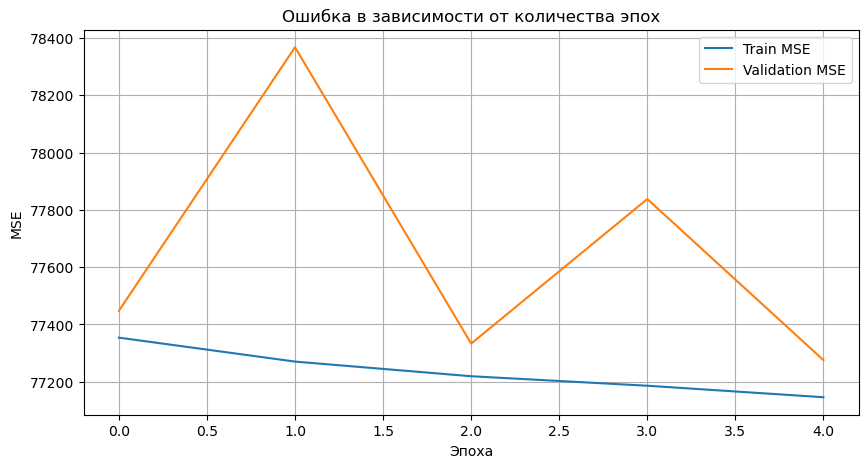

In [278]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.title('Ошибка в зависимости от количества эпох')
plt.legend()
plt.grid(True)
plt.show()

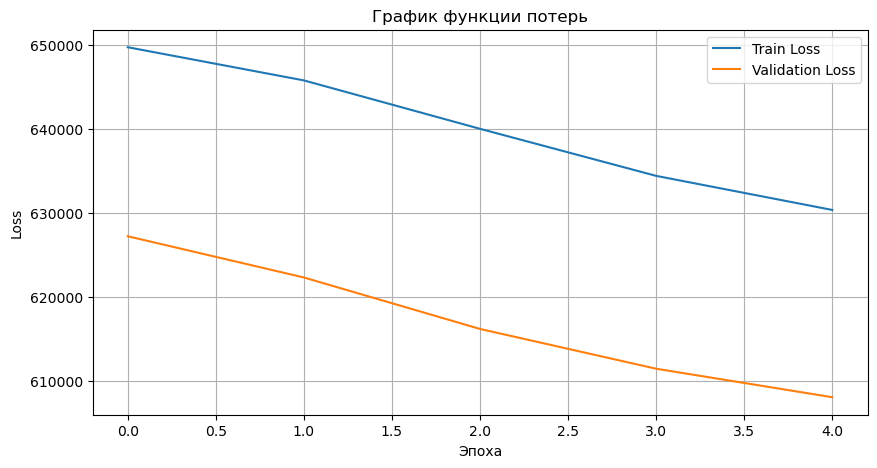

In [66]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('График функции потерь')
plt.legend()
plt.grid(True)
plt.show()

## Keras Tuner

In [300]:
import keras_tuner
import keras

In [311]:
def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(
      hp.Choice('units', [32, 64, 128]),
      activation='relu'))
  model.add(keras.layers.Dense(1, activation='relu'))
  model.compile(loss='mse')
  return model

In [312]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)

Reloading Tuner from .\untitled_project\tuner0.json


In [313]:
tuner.search(X_reg_train[:2000], y_reg_train[:2000], epochs=5, validation_data=(X_reg_test, y_reg_test))

In [314]:
tf.get_logger().setLevel('ERROR')
best_model = tuner.get_best_models()[0]

In [316]:
best_hp = tuner.get_best_hyperparameters(1)[0]

print("Лучшие гиперпараметры:")
for param, value in best_hp.values.items():
    print(f"  {param}: {value}")


Лучшие гиперпараметры:
  units: 32


In [317]:
model2 = Sequential([
    Dense(32, activation='relu', input_shape=(X_reg_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

In [318]:
model2.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [319]:
history = model2.fit(X_reg_train, y_reg_train, epochs=5, validation_data=(X_reg_test, y_reg_test), verbose=1)

Epoch 1/5
16099/16099 [==============================] - 110s 7ms/step - loss: 96347.7500 - mae: 227.8064 - val_loss: 80592.5625 - val_mae: 214.0199
Epoch 2/5
16099/16099 [==============================] - 107s 7ms/step - loss: 80408.4844 - mae: 211.7097 - val_loss: 80448.3750 - val_mae: 214.2078
Epoch 3/5
16099/16099 [==============================] - 108s 7ms/step - loss: 80153.0234 - mae: 211.3273 - val_loss: 79451.9609 - val_mae: 211.2210
Epoch 4/5
16099/16099 [==============================] - 108s 7ms/step - loss: 78154.4531 - mae: 208.1976 - val_loss: 77833.7891 - val_mae: 206.3997
Epoch 5/5
16099/16099 [==============================] - 108s 7ms/step - loss: 77570.2656 - mae: 207.2478 - val_loss: 77556.9375 - val_mae: 207.1989


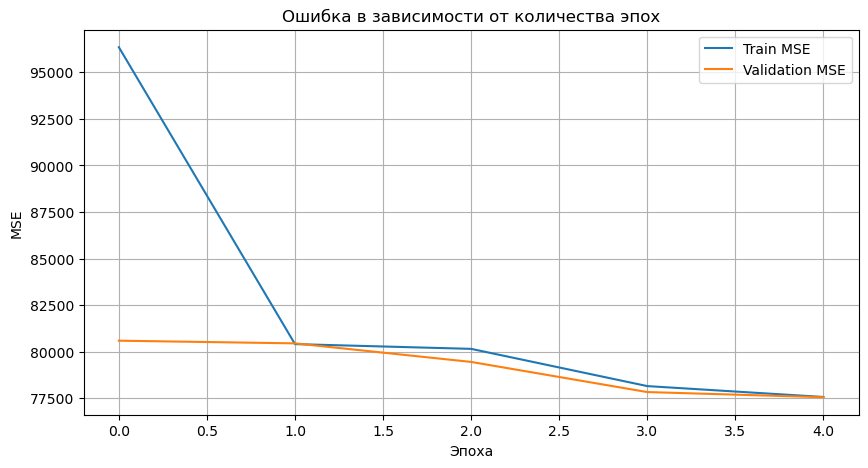

In [320]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.title('Ошибка в зависимости от количества эпох')
plt.legend()
plt.grid(True)
plt.show()

## SGD

In [58]:
model2 = Sequential([
    Dense(32, activation='tanh', input_shape=(X_reg_train.shape[1],)),
    Dense(32, activation='tanh'),
    Dense(1)
])

In [59]:
model2.compile(optimizer='sgd', loss='mse', metrics=['mae'])

In [60]:
history = model2.fit(X_reg_train[:2000], y_reg_train[:2000], epochs=5, validation_data=(X_reg_test, y_reg_test), verbose=1)

Epoch 1/5
63/63 [==============================] - 13s 196ms/step - loss: 189140.9375 - mae: 325.2471 - val_loss: 125382.5234 - val_mae: 283.9363
Epoch 2/5
63/63 [==============================] - 12s 186ms/step - loss: 148357.5156 - mae: 302.8150 - val_loss: 140296.3281 - val_mae: 289.7394
Epoch 3/5
63/63 [==============================] - 11s 184ms/step - loss: 119890.8281 - mae: 268.6640 - val_loss: 98053.1875 - val_mae: 240.9202
Epoch 4/5
63/63 [==============================] - 11s 182ms/step - loss: 108488.6406 - mae: 253.1532 - val_loss: 104475.3594 - val_mae: 248.8301
Epoch 5/5
63/63 [==============================] - 11s 182ms/step - loss: 110069.2266 - mae: 253.8632 - val_loss: 100200.3516 - val_mae: 240.6947


## RMSprop

In [61]:
model2 = Sequential([
    Dense(32, activation='tanh', input_shape=(X_reg_train.shape[1],)),
    Dense(32, activation='tanh'),
    Dense(1)
])

In [62]:
model2.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [63]:
history = model2.fit(X_reg_train[:2000], y_reg_train[:2000], epochs=5, validation_data=(X_reg_test, y_reg_test), verbose=1)

Epoch 1/5
63/63 [==============================] - 27s 190ms/step - loss: 649771.0625 - mae: 689.2623 - val_loss: 627231.6250 - val_mae: 681.2579
Epoch 2/5
63/63 [==============================] - 12s 190ms/step - loss: 645814.0000 - mae: 687.0766 - val_loss: 622315.3125 - val_mae: 677.9559
Epoch 3/5
63/63 [==============================] - 12s 189ms/step - loss: 640041.7500 - mae: 682.7065 - val_loss: 616177.3125 - val_mae: 672.8166
Epoch 4/5
63/63 [==============================] - 12s 190ms/step - loss: 634430.1875 - mae: 677.8799 - val_loss: 611435.4375 - val_mae: 668.7720
Epoch 5/5
63/63 [==============================] - 12s 188ms/step - loss: 630367.4375 - mae: 674.6116 - val_loss: 608036.4375 - val_mae: 666.1107


In [64]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 32)                96        
                                                                 
 dense_15 (Dense)            (None, 32)                1056      
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,185
Trainable params: 1,185
Non-trainable params: 0
_________________________________________________________________


# Классификация

## Optuna

In [38]:
def objective(trial):
    n_layers = trial.suggest_int("n_layers", 1, 3)
    units = trial.suggest_int("units", 32, 128, step=32)
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "rmsprop"])
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    if optimizer_name == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model = Sequential()
    model.add(Dense(units, activation=activation, input_shape=(X_cl_train.shape[1],)))
    for _ in range(n_layers - 1):
        model.add(Dense(units, activation=activation))
    model.add(Dense(1, activation="sigmoid")) 

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    history = model.fit(
        X_cl_train[:2000], y_cl_train[:2000],
        validation_data=(X_cl_test, y_cl_test),
        batch_size=batch_size,
        epochs=5,
        verbose=1
    )

    val_accuracy = max(history.history["val_accuracy"])
    return 1.0 - val_accuracy  

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=3)

[I 2025-05-29 23:56:50,783] A new study created in memory with name: no-name-0209c451-9b8c-43df-a56d-d061a9713b80


Epoch 1/5
125/125 [==============================] - 11s 81ms/step - loss: 56.8627 - accuracy: 0.5850 - val_loss: 1.8948 - val_accuracy: 0.6051
Epoch 2/5
125/125 [==============================] - 10s 78ms/step - loss: 1.9845 - accuracy: 0.5755 - val_loss: 5.7566 - val_accuracy: 0.6591
Epoch 3/5
125/125 [==============================] - 10s 79ms/step - loss: 1.5658 - accuracy: 0.5760 - val_loss: 2.7761 - val_accuracy: 0.6537
Epoch 4/5
125/125 [==============================] - 10s 78ms/step - loss: 1.7639 - accuracy: 0.5485 - val_loss: 2.1315 - val_accuracy: 0.6580
Epoch 5/5
125/125 [==============================] - 10s 79ms/step - loss: 1.2070 - accuracy: 0.5835 - val_loss: 1.0035 - val_accuracy: 0.6511


[I 2025-05-29 23:57:40,517] Trial 0 finished with value: 0.3409382104873657 and parameters: {'n_layers': 1, 'units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.000551440847063398, 'batch_size': 16}. Best is trial 0 with value: 0.3409382104873657.


Epoch 1/5
32/32 [==============================] - 3s 90ms/step - loss: 0.6492 - accuracy: 0.6435 - val_loss: 0.6429 - val_accuracy: 0.6563
Epoch 2/5
32/32 [==============================] - 3s 80ms/step - loss: 0.6358 - accuracy: 0.6635 - val_loss: 0.6455 - val_accuracy: 0.6573
Epoch 3/5
32/32 [==============================] - 3s 84ms/step - loss: 0.6318 - accuracy: 0.6650 - val_loss: 0.6544 - val_accuracy: 0.6186
Epoch 4/5
32/32 [==============================] - 3s 84ms/step - loss: 0.6320 - accuracy: 0.6655 - val_loss: 0.6488 - val_accuracy: 0.6553
Epoch 5/5
32/32 [==============================] - 2s 78ms/step - loss: 0.6318 - accuracy: 0.6635 - val_loss: 0.6479 - val_accuracy: 0.6544


[I 2025-05-29 23:57:54,304] Trial 1 finished with value: 0.3427377939224243 and parameters: {'n_layers': 1, 'units': 128, 'activation': 'tanh', 'optimizer': 'rmsprop', 'learning_rate': 0.0008908243431931103, 'batch_size': 64}. Best is trial 0 with value: 0.3409382104873657.


Epoch 1/5
63/63 [==============================] - 6s 87ms/step - loss: 46.9084 - accuracy: 0.5170 - val_loss: 4.8894 - val_accuracy: 0.5793
Epoch 2/5
63/63 [==============================] - 5s 80ms/step - loss: 3.2190 - accuracy: 0.5575 - val_loss: 2.5944 - val_accuracy: 0.6374
Epoch 3/5
63/63 [==============================] - 5s 81ms/step - loss: 2.3029 - accuracy: 0.5640 - val_loss: 2.7874 - val_accuracy: 0.6062
Epoch 4/5
63/63 [==============================] - 5s 79ms/step - loss: 3.1561 - accuracy: 0.5760 - val_loss: 2.2856 - val_accuracy: 0.4532
Epoch 5/5
63/63 [==============================] - 5s 80ms/step - loss: 2.3157 - accuracy: 0.5435 - val_loss: 1.3319 - val_accuracy: 0.3923


[I 2025-05-29 23:58:20,453] Trial 2 finished with value: 0.3625946044921875 and parameters: {'n_layers': 2, 'units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.0006997659225087932, 'batch_size': 32}. Best is trial 0 with value: 0.3409382104873657.


In [39]:
print("Лучшие параметры:", study.best_params)
print("Лучшее значение accuracy:", study.best_value)

Лучшие параметры: {'n_layers': 1, 'units': 64, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.000551440847063398, 'batch_size': 16}
Лучшее значение accuracy: 0.3409382104873657


In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

n_layers = 1
units = 64
activation = 'relu'
learning_rate = 0.000551440847063398

optimizer = Adam(learning_rate=learning_rate)

model = Sequential()
model.add(Dense(units, activation=activation, input_shape=(X_cl_train.shape[1],)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

hist = model.fit(X_cl_train, y_cl_train, batch_size=16, epochs=5, validation_data=(X_cl_test, y_cl_test))

Epoch 1/5
15977/15977 [==============================] - 107s 7ms/step - loss: 1.7694 - accuracy: 0.5123 - val_loss: 1.0430 - val_accuracy: 0.6522
Epoch 2/5
15977/15977 [==============================] - 107s 7ms/step - loss: 1.4906 - accuracy: 0.5125 - val_loss: 0.9631 - val_accuracy: 0.4296
Epoch 3/5
15977/15977 [==============================] - 106s 7ms/step - loss: 1.4394 - accuracy: 0.5143 - val_loss: 1.1882 - val_accuracy: 0.6587
Epoch 4/5
15977/15977 [==============================] - 105s 7ms/step - loss: 1.3762 - accuracy: 0.5144 - val_loss: 1.1283 - val_accuracy: 0.6589
Epoch 5/5
15977/15977 [==============================] - 107s 7ms/step - loss: 1.3445 - accuracy: 0.5164 - val_loss: 1.7158 - val_accuracy: 0.3449


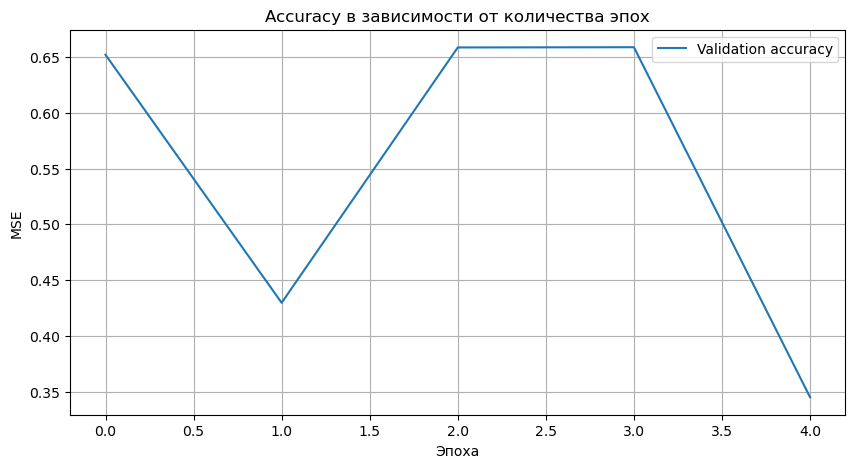

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(hist.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.title('Accuracy в зависимости от количества эпох')
plt.legend()
plt.grid(True)
plt.show()

## Keras Tuner

In [ ]:
import keras_tuner
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Dense(
        hp.Choice('units', [32, 64, 128]),
        activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))  
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy']) 
    return model

In [ ]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_accuracy',  
    max_trials=5)

tuner.search(X_cl_train[:2000], y_cl_train[:2000], 
             epochs=5, 
             validation_data=(X_cl_test, y_cl_test))

tf.get_logger().setLevel('ERROR')
best_model = tuner.get_best_models()[0]
best_hp = tuner.get_best_hyperparameters(1)[0]

print("Лучшие гиперпараметры:")
for param, value in best_hp.values.items():
    print(f"  {param}: {value}")


model2 = Sequential([
    Dense(32, activation='relu', input_shape=(X_cl_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model2.fit(X_cl_train, y_cl_train, epochs=5, 
                     validation_data=(X_cl_test, y_cl_test), verbose=1)

Reloading Tuner from .\untitled_project\tuner0.json
Лучшие гиперпараметры:
  units: 8
Epoch 1/5
7989/7989 [==============================] - 59s 7ms/step - loss: 1.7666 - accuracy: 0.5103 - val_loss: 3.9544 - val_accuracy: 0.6550
Epoch 2/5
7989/7989 [==============================] - 57s 7ms/step - loss: 1.1561 - accuracy: 0.5156 - val_loss: 0.8362 - val_accuracy: 0.5014
Epoch 3/5
7989/7989 [==============================] - 57s 7ms/step - loss: 1.0180 - accuracy: 0.5163 - val_loss: 1.1952 - val_accuracy: 0.3760
Epoch 4/5
7989/7989 [==============================] - 57s 7ms/step - loss: 0.8611 - accuracy: 0.5207 - val_loss: 0.6782 - val_accuracy: 0.5925
Epoch 5/5
7989/7989 [==============================] - 57s 7ms/step - loss: 0.7966 - accuracy: 0.5237 - val_loss: 0.7545 - val_accuracy: 0.6532


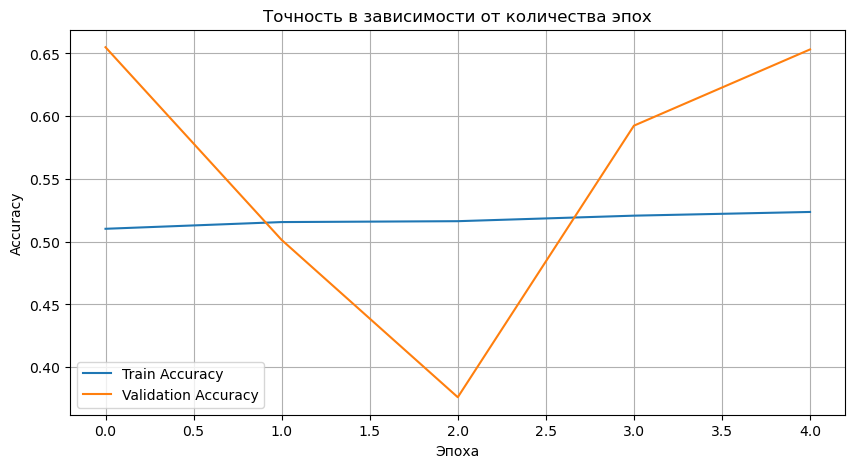

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.title('Точность в зависимости от количества эпох')
plt.legend()
plt.grid(True)
plt.show()

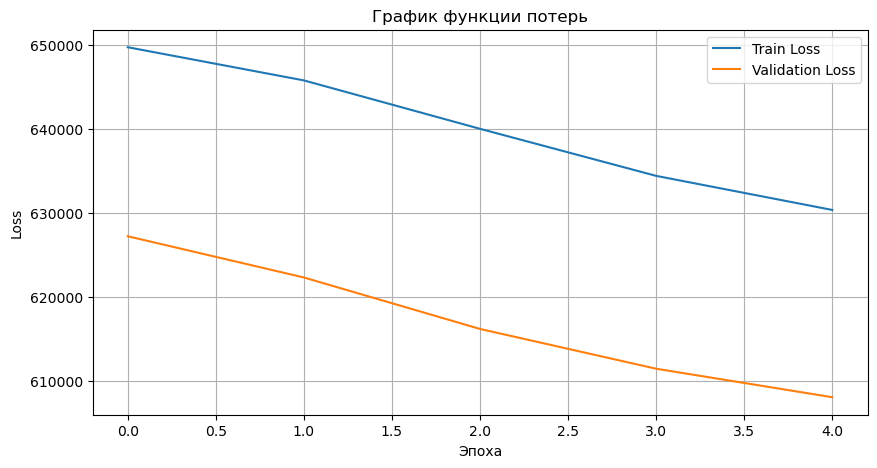

In [65]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('График функции потерь')
plt.legend()
plt.grid(True)
plt.show()

## Архитектура модели

In [50]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                96        
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,185
Trainable params: 1,185
Non-trainable params: 0
_________________________________________________________________


## SGD

In [71]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

model2 = Sequential([
    Dense(32, activation='tanh', input_shape=(X_cl_train.shape[1],)),
    Dense(32, activation='tanh'),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer=SGD(learning_rate=0.01), 
               loss='binary_crossentropy',
               metrics=['accuracy'])

history = model2.fit(
    X_cl_train[:2000], y_cl_train[:2000],
    epochs=5,
    validation_data=(X_cl_test, y_cl_test),
    verbose=1
)

Epoch 1/5
63/63 [==============================] - 6s 90ms/step - loss: 0.6515 - accuracy: 0.6525 - val_loss: 0.6460 - val_accuracy: 0.6538
Epoch 2/5
63/63 [==============================] - 5s 85ms/step - loss: 0.6400 - accuracy: 0.6665 - val_loss: 0.6511 - val_accuracy: 0.6490
Epoch 3/5
63/63 [==============================] - 5s 79ms/step - loss: 0.6393 - accuracy: 0.6635 - val_loss: 0.6450 - val_accuracy: 0.6499
Epoch 4/5
63/63 [==============================] - 5s 80ms/step - loss: 0.6390 - accuracy: 0.6670 - val_loss: 0.6436 - val_accuracy: 0.6519
Epoch 5/5
63/63 [==============================] - 5s 82ms/step - loss: 0.6383 - accuracy: 0.6625 - val_loss: 0.6426 - val_accuracy: 0.6545


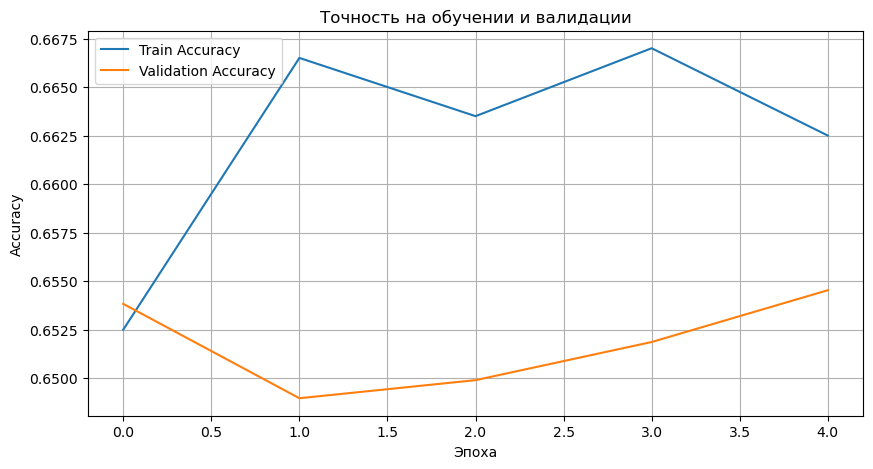

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.title('Точность на обучении и валидации')
plt.legend()
plt.grid(True)
plt.show()

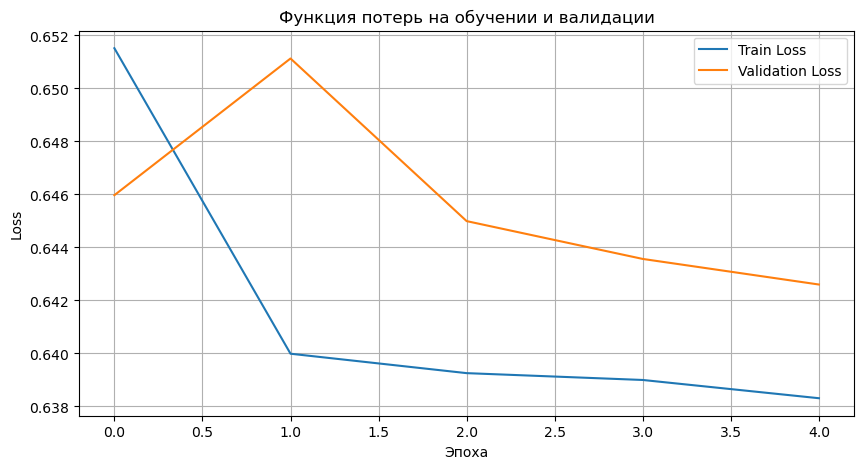

In [74]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('Функция потерь на обучении и валидации')
plt.legend()
plt.grid(True)
plt.show()


## RMSprop

In [75]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import RMSprop

model2 = Sequential([
    Dense(32, activation='tanh', input_shape=(X_cl_train.shape[1],)),
    Dense(32, activation='tanh'),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer=RMSprop(learning_rate=0.01), 
               loss='binary_crossentropy',
               metrics=['accuracy'])

history = model2.fit(
    X_cl_train[:2000], y_cl_train[:2000],
    epochs=5,
    validation_data=(X_cl_test, y_cl_test),
    verbose=1
)

Epoch 1/5
63/63 [==============================] - 6s 86ms/step - loss: 0.6814 - accuracy: 0.6360 - val_loss: 0.6506 - val_accuracy: 0.6414
Epoch 2/5
63/63 [==============================] - 5s 80ms/step - loss: 0.6492 - accuracy: 0.6485 - val_loss: 0.6459 - val_accuracy: 0.6589
Epoch 3/5
63/63 [==============================] - 5s 81ms/step - loss: 0.6464 - accuracy: 0.6580 - val_loss: 0.6413 - val_accuracy: 0.6589
Epoch 4/5
63/63 [==============================] - 5s 80ms/step - loss: 0.6438 - accuracy: 0.6615 - val_loss: 0.6383 - val_accuracy: 0.6589
Epoch 5/5
63/63 [==============================] - 5s 81ms/step - loss: 0.6451 - accuracy: 0.6595 - val_loss: 0.6386 - val_accuracy: 0.6589


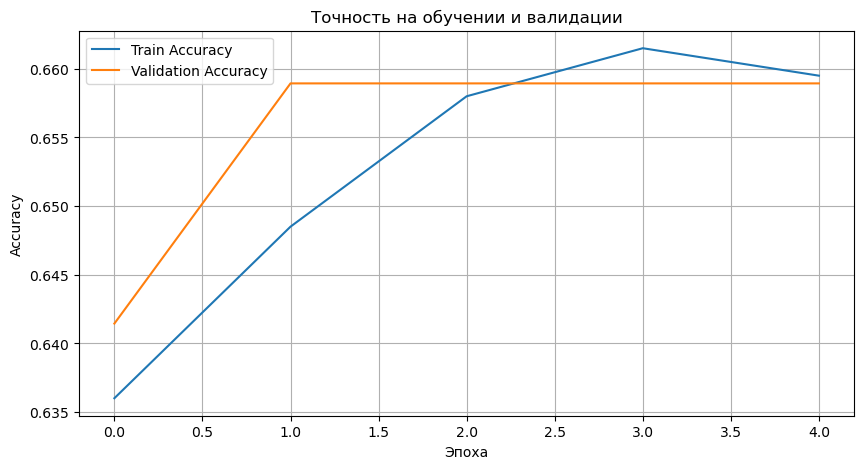

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.title('Точность на обучении и валидации')
plt.legend()
plt.grid(True)
plt.show()

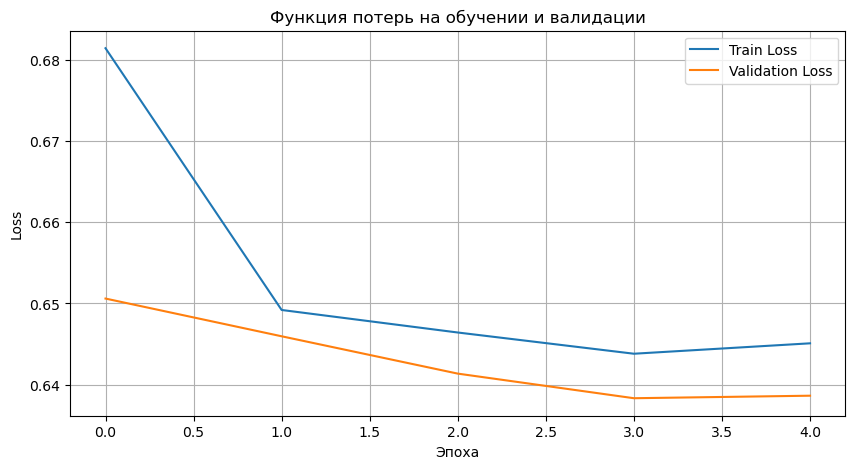

In [77]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('Функция потерь на обучении и валидации')
plt.legend()
plt.grid(True)
plt.show()


In [68]:
import pandas as pd

columns = [
    "Регрессор/Фреймворк",

    "Test MSE", "Test MAE", "Test Кол-во эпох", "Test Оптимизатор",
]

data = [
    ["Tensor flow", 77145.99, 206.56, 5, "Optuna"],
    ["Tensor flow", 77510.33, 207.24, 5, "Keras Tuner"],
    ["Tensor flow", 110069.13, 253.96, 5, "SGD"],
    ["Tensor flow", 630370.52, 674.04, 5, "RMSprop"],
]

df = pd.DataFrame(data, columns=columns)

In [69]:
df

,Регрессор/Фреймворк,Test MSE,Test MAE,Test Кол-во эпох,Test Оптимизатор
0,Tensor flow,77145.99,206.56,5,Optuna
1,Tensor flow,77510.33,207.24,5,Keras Tuner
2,Tensor flow,110069.13,253.96,5,SGD
3,Tensor flow,630370.52,674.04,5,RMSprop


In [81]:
import pandas as pd

columns = [
    "Регрессор/Фреймворк",

    "Test accuracy", "Количество эпох", "Оптимизатор"
]

data = [
    ["Tensorflow", 0.65, 5, "Optuna"],
    ["Tensorflow", 0.65, 5, "Keras Tuner"],
    ["Tensorflow", 0.65, 5, "SGD"],
    ["Tensorflow", 0.68, 5, "RMSprop"],
]

df = pd.DataFrame(data, columns=columns)
df

,Регрессор/Фреймворк,Test accuracy,Количество эпох,Оптимизатор
0,Tensor flow,0.65,5,Optuna
1,Tensor flow,0.65,5,Keras Tuner
2,Tensor flow,0.65,5,SGD
3,Tensor flow,0.68,5,RMSprop


# Деплой

## Классификация

In [95]:
X_jack = pd.DataFrame(
    columns = df1.drop(columns=['trip_duration'], axis=1).columns,
    data = [[1, -73.953918, 40.778873, -73.963875, 40.771164, 1, 2, 16, 0.012592, 0, 1]])

In [98]:
mlp_reg.predict(X_jack[["dropoff_latitude", "distance"]])

C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


array([39.75718832])

То есть поездка составит 39 минут

# Регрессия

In [107]:
X_jack = pd.DataFrame(
    columns = df2.drop(columns=['Delay'], axis=1).columns,
    data = [[305, 3036, 144, 58, 4, 1195, 131]])

In [110]:
mlp_cl.predict(X_jack[["Flight", "Time"]])

C:\Users\Denis\Miniconda3\envs\myenv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


array([0], dtype=int64)

То есть задержки нет

# Вывод

Нейросетевые модели в общем случае должны лучше справляться с предсказаниями, однако в нашем случае было мало времени на обучение моделей, поэтому их качество оказалось хуже, чем не нейросетевые модели